# BiblioAnalysis_OnDev

### Aims
- This jupyter notebook results from the use analysis of BiblioTools2jupyter notebook and a new implementation of the following parts:
    - Parsing: replaced and tested
    - Corpus description: replaced and tested
    - Filtering: replaced and tested, integrating the "EXCLUSION" mode and the recursive filtering 

### BiblioTool3.2 source
http://www.sebastian-grauwin.com/bibliomaps/download.html 

### List of initial Python packages extracted from  BiblioTool3.2
- biblio_parser.py	⇒ pre-processes WOS / Scopus data files,
- corpus_description.py	⇒ performs a frequency analysis of the items in corpus,
- filter.py	⇒ filters the corpus according to a range of potential queries but still too specific
- biblio_coupling.py	⇒ performs a BC anaysis of the corpus,
- cooc_graphs.py	⇒ produces various co-occurrence graphs based on the corpus (call parameters changed)

### Specifically required list of pip install  specifically required
- !pip3 install squarify 
- !pip3 install inquirer

### Required nltk downloads
- nltk.download('punkt')
- nltk.download('averaged_perceptron_tagger')

In [1]:
# Standard library imports
import sys
import json
from pathlib import Path

## User identification
root = Path.home()

## Building dict of paths for potential users (to be completed with the specific paths of new users) 
user = {}
if root == Path('/Users/amal'):
    user = {
        'mac_packages' : '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages',
        'path1' : 'My_Jupyter/',
        'path2' : 'BiblioAnalysis Data/',
        'path3' : 'BiblioAnalysis/Config/'
        }

elif root == Path('C:/Users/franc'):
    user = {
        'mac_packages' : '',
        'path1' : '',
        'path2' : 'BiblioAnalysis Data/',
        'path3' : 'BiblioAnalysis/Config/'
        }
else:
    user = {
        'mac_packages' : '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages',
        'path1' : 'GitHubClone/',
        'path2' : 'BiblioAnalysis Data/',
        'path3' : 'BiblioAnalysis/Config/'
        }    

## Add path of 'site-packages' where useful packages are stored on MAC-OS; no impact for Windows
sys.path.append(user['mac_packages'])

## Getting complementary information from user configuration file
file_config_users = root / Path(user['path1'] + user['path3'] + 'config_users.json') 
with open(file_config_users, "r") as read_file:
    config_users = json.load(read_file)    
user_id =  config_users['users']
database_type =  config_users['database']
myprojectname = config_users['myprojectname']
expert =  config_users['expert']

## Folder containing the folder Utils
rep_utils = root / Path(user['path1'] + 'BiblioAnalysis/' + 'Utils')

## Specific files for scopus type database
scopus_cat_codes = 'scopus_cat_codes.txt'
scopus_journals_issn_cat = 'scopus_journals_issn_cat.txt'

print('"' + user_id + '"'+ ' specific paths set')

"amal" specific paths set


## Data parsing
- articles.dat is the central file, listing all the publications within the corpus. It contains informations such as the document type (article, letter, review, conf proceeding, etc), title, year of publication, publication source, doi, number of citations (given by WOS or Scopus at the time of the extraction) AND a unique identifier used in all the other files to identify a precise publication.
- database.dat keeps track of the origin of the data, some part of the analysis being specific to WOS or Scopus data.
- authors.dat lists all authors names associated to all publications ID.
- addresses.dat lists all adresses associated to all publications ID, along with a specific ID for each adresse line. These adresses are reported as they appear in the raw data, without any further processing.
- countries.dat lists all countries associated to all publications ID and adresses lines ID. The countries are extracted from the adresses fields of the raw data, with some cleaning (changing mentions of US states and UK countries to respectively the USA and UK).
- institutions.dat lists all the comma-separated entities appearing in the adresses field associated to all publications ID and adresses lines ID, except those refering to a physical adresses. These entities correspond to various name variants of universities, organisms, hospitals, labs, services, departments, etc as they appear in the raw data. No treatment is made to e.g. filtering out the entities corresponding a given hierarchy level.
- keywords.dat lists various types of keywords associated to all publications ID. "AK" keywords correspond to Author's keywords. "IK" keywords correspond to either WOS or Scopus keywords, which are built based on the authors' keywords, the title and abstract. "TK" correspond to title words (from which we simply remove common words and stop words - no stemming is performed). TK are especially useful when studying pre-90's publications, when the use of keywords was not yet standard.
- references.dat lists all the references associated to all publications ID. The rawdata is parsed to store the first author name, title, source, volume and page of each reference of the raw "references" field.
- subjects.dat lists all subject categories associated to all publications ID (a journal may be associated to many subject category). WOS classifies the sources it indexes into ∼ 250 categories, that are reported in the extracted data. Scopus classifies its sources into 27 major categories and ∼ 300 sub-categories, none of which are reported in the extracted data. We use Elsevier Source Title List (october 2017 version) to retrieve that information. The "subject.dat" contains the info relative to the major categories.
- subjects2.dat lists Scopus's sub-categories, if the use database is Scopus.
- AA_log.txt keeps track of the date/time the script was executed and of all the messages displayed on the terminal (number of publications extracted, % of references rejected, etc).

In [2]:
# Standard libraries import
import os

# Third party imports
import Utils.BiblioParser as parser


## ##################################################
## ##################################################
## ##################################################
## Building the names of the useful folders

    # Folder containing the wos or scopus file to process
in_dir_parsing = root / Path(user['path2'] + myprojectname +'rawdata')

    # Folder containing the output files of the data parsing 
out_dir_parsing = root / Path(user['path2'] + myprojectname + 'parsing')
if not os.path.exists(out_dir_parsing):
    os.mkdir(out_dir_parsing)

## Running function biblio_parser
parser.biblio_parser(in_dir_parsing, out_dir_parsing, database_type, expert, rep_utils)

##  Corpus description
Before doing anything else, you should get a general idea of the content of your database. Execute the following command line:

- python BiblioTools3.2/describe_corpus.py -i myprojectname/ -v <br>

The options -i indicates the data input folder and the option -v puts the verbose mode on (detailed info about the script process will be displayed in the terminal). This script performs several basic tasks:

- it performs a series of frequency analysis, computing the number of occurrences of each item (authors, keywords, references, etc) within the publications of the corpus. These frequencies are automatically stored into several "freq_xxx.dat" files within a newly created "freq" folder.
- it performs a series of generic statistical analysis, storing the numbers of distinct items of each type (e.g. there are x distinct keyword in the corpus ), the distributions of number of occurrences of each item (e.g. there are x keywords appearing in at least y publications) and the distribution of number of items per publication (e.g.there are x% of publications with y keywords). All these statistics are stored in the "DISTRIBS_itemuse.json" file.
- it also performs a co-occurrence analysis, computing the number of co-occurrence of pairs of items among the top 100 most frequent items of each type (e.g. computing how often the two most used keywords appear together in the same publications). The results of this analysis are stored in the "coocnetworks.json" file. More systematic co-occurrence analysis can also be performed with another script, cf the Co-occurrence Maps section below.
All the generated files can be opened and read with a simple text editor. The freq_xxx.dat, listing items by order of frequency, can also be read in a spreadsheet software such as excel. All the files are however primarily made to be read in the BiblioMaps interface.

Choose the item for treemap in the tk window
Item selected: subjects
Enter the number of items to be used for the treemap (min = 1, max = 70): 20


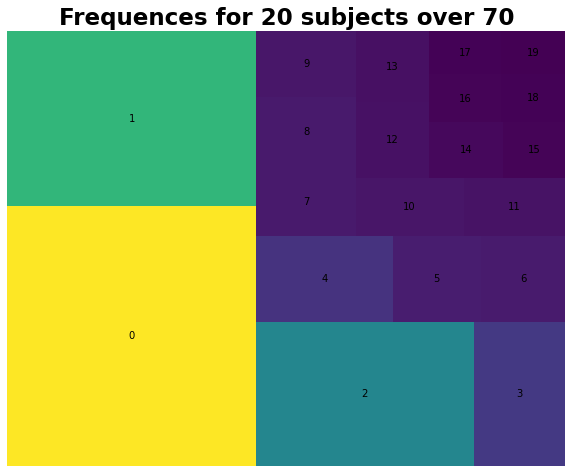

alias subjects                                                    frequency
0     Neurosciences & Neurology                                   187
1     Psychiatry                                                  126
2     Psychology                                                  90
3     Behavioral Sciences                                         38
4     Geriatrics & Gerontology                                    34
5     Computer Science                                            22
6     Environmental Sciences & Ecology                            21
7     History & Philosophy of Science                             20
8     Zoology                                                     20
9     Pharmacology & Pharmacy                                     19
10    Public, Environmental & Occupational Health                 18
11    Engineering                                                 17
12    Philosophy                                                  16
13    Science & Technolog

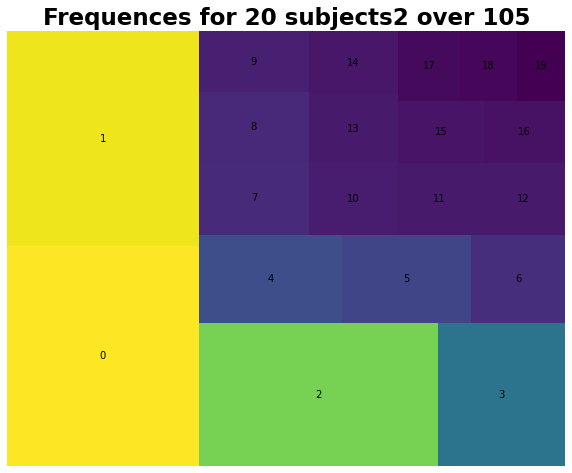

alias subjects2                                                   frequency
0     Psychiatry                                                  126
1     Neurosciences                                               123
2     Clinical Neurology                                          102
3     Psychology                                                  54
4     Behavioral Sciences                                         38
5     Geriatrics & Gerontology                                    34
6     Psychology, Experimental                                    25
7     Psychology, Clinical                                        24
8     Gerontology                                                 23
9     History & Philosophy Of Science                             20
10    Zoology                                                     19
11    Public, Environmental & Occupational Health                 18
12    Environmental Sciences                                      18
13    Pharmacology & Pha

In [3]:
# Third party imports
import Utils.BiblioDescription as desc
import Utils.GUI_utils as gui

## ##################################################
## ##################################################
## ##################################################
## Building the names of the useful folders

    # Folder containing the wos or scopus parsed files
in_dir_corpus = out_dir_parsing

    # Folder containing the wos or scopus parsed and analysed files
out_dir_corpus = root / Path(user['path2'] + myprojectname + 'freq')
if not os.path.exists(out_dir_corpus):
    os.mkdir(out_dir_corpus)

## Running describe_corpus
verbose = False
desc.describe_corpus(in_dir_corpus, out_dir_corpus, verbose)


## Running plot of treemap for a selected item_treemap
path_treemap = user['path2'] + myprojectname + 'freq/'
renew_treemap = 'y'
while renew_treemap == 'y' :
    print('Choose the item for treemap in the tk window')
    item_treemap = gui.item_selection()
    file_name_treemap = root / Path(path_treemap + 'freq_'+ item_treemap +'.dat')
    print("Item selected:",item_treemap)
    gui.treemap_item(item_treemap, file_name_treemap)
    print() 
    print()
    renew_treemap = input("Treemap for a new item ? (y/n): ")


### Filtering the data
#### To be run after corpus description to allow using the following functions : describe_corpus() , treemap_item()

If, upon exploring the nature of the data you realize that before going further you'd prefer to filter your corpus based on some characteristic (keeping only the publications from certain years, using some keywords or references, written by some authors from some countries, etc), you can filter the initial corpus thanks to the script:

- python BiblioTools3.2/filter.py -i myprojectname/ -o myprojectname_filtered -v <br>

Edit the 'filter.py' file to specify your filters. You'll also need to create a new "myprojectname_filtered" main folder before running the script.
- create the files articles.dat, addresses.dat, authors.dat, countries.dat, institutions.dat, keywords.dat, references.dat, subjects.dat, subjects2.dat

Filters configuration set and saved ? (y/n): y


Choose the item for treemap in the tk window
Item selected: subjects
Enter the number of items to be used for the treemap (min = 1, max = 69): 20


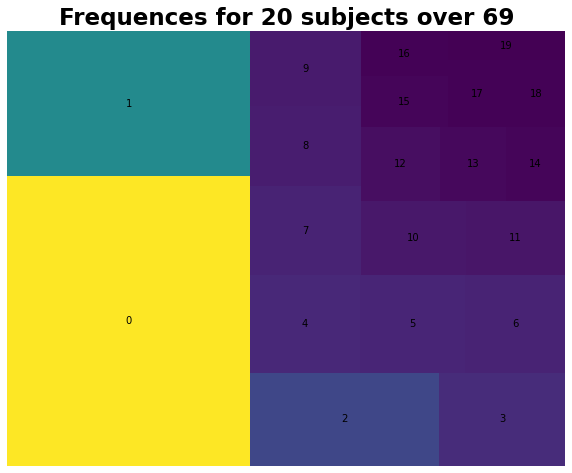

alias subjects                                                    frequency
0     Neurosciences & Neurology                                   144
1     Psychology                                                  72
2     Behavioral Sciences                                         36
3     Geriatrics & Gerontology                                    24
4     Computer Science                                            22
5     Environmental Sciences & Ecology                            21
6     History & Philosophy of Science                             20
7     Zoology                                                     20
8     Public, Environmental & Occupational Health                 18
9     Engineering                                                 17
10    Philosophy                                                  16
11    Science & Technology - Other Topics                         15
12    Nutrition & Dietetics                                       12
13    Social Sciences - Ot

In [4]:

# Standard library imports 
import shutil                      

# Third party imports
import Utils.BiblioFilter as filt 
import Utils.BiblioDescription as desc

## Recursive filtering

# Allows prints in filter_corpus_new function
verbose = False

# String used to set the output folder name of the subsequent filterings in the recursive_filter function
path_filter = user['path2'] + myprojectname + 'filter' 

## Building the absolute file name of filter configuration file for the user
file_config_filters = root / Path(user['path1'] + user['path3'] + 'config_filters.json')

# Initialization of parameters for recursive filtering
filtering_step = 1
while True:
    
    ## Building the names of the useful folders and creating the output folder if not find 
    if filtering_step == 1:
        in_dir_filter = out_dir_parsing
    else:
        renew_filtering = input(
            "Apply a new filtering process ? (y/n): "
            )   
        in_dir_filter = root / Path(path_filter + '_' + str(filtering_step-1))
        if renew_filtering == "n":
            break
   
    out_dir_filter = root / Path(path_filter + '_' + str(filtering_step))
    if not os.path.exists(out_dir_filter):
        os.mkdir(out_dir_filter)
    
    congig_filters = "n"
    while congig_filters == "n":
        congig_filters = input(
            "Filters configuration set and saved ? (y/n): "
            )
        
    # Running function filter_corpus_new
    filt.filter_corpus_new(in_dir_filter, out_dir_filter, verbose, file_config_filters)

    # Treemap plot by a corpus item after filtering
        # Folder containing the wos or scopus parsed and filtered files
    in_dir_corpus = out_dir_filter

        # Folder containing the wos or scopus parsed, filtered and analysed files
    out_dir_corpus = root / Path(user['path2'] + myprojectname + 'freq' + '_' + str(filtering_step))
    if not os.path.exists(out_dir_corpus):
        os.mkdir(out_dir_corpus)
    
        # Copying 'database.dat' file in the freq folder for the use in describe_corpus function 
    original = root / Path(user['path2'] + myprojectname + 'parsing/database.dat')
    target = root / Path(user['path2'] + myprojectname + 'filter' + '_' + str(filtering_step) + '/database.dat')
    shutil.copyfile(original, target)
    
        # Running describe_corpus
    verbose = False
    desc.describe_corpus(in_dir_corpus, out_dir_corpus, verbose)

        # Running plot of treemap for selected item_treemap
    path_treemap = user['path2'] + myprojectname + 'freq_' + str(filtering_step) + "/"
    file_name_treemap = root / Path(path_treemap + 'freq_'+ item_treemap +'.dat')
    renew_treemap = 'y'    
    while renew_treemap == 'y' :
        print()
        print()
        print('Choose the item for treemap in the tk window')
        item_treemap = gui.item_selection()
        file_name_treemap = root / Path(path_treemap + 'freq_'+ item_treemap +'.dat')
        print("Item selected:",item_treemap)
        gui.treemap_item(item_treemap, file_name_treemap)
        print() 
        print()
        renew_treemap = input("Treemap for a new item ? (y/n):") 
  
    filtering_step=filtering_step + 1


### Bibliographic Coupling analysis
You may execute the bibliographic coupling script with the command line:

- python BiblioTools3.2/biblio_coupling.py -i myprojectname/ -v

Example of BC clusters network visualisation created in Gephi and of one cluster's ID card, part of a lengthy PDF document listing the ID cards of all clusters.

The options -i indicates the data input folder and the option -v puts the verbose mode on. This script execute a number of tasks:

- It first creates the BC network, computing Kessler similarities between each pair of publications
- It detects a first set of clusters (which we will refer to as "TOP") using Thomas Aynaud's python implementation of the louvain algorithm. A second set of clusters ("SUBTOP") is then computed by applying the same algorithm to the publications in each TOP cluster, hence providing a 2-level hierarchical partition.
- The script will then asked whether you want to create output files for the cluster. By default, the script will output information only for clusters with more than 50 publications, but the script will asked you to confirm / change this threshold. Several files will then be created by the script:
    - Output 1: two json files, storing information about the clusters, to be used in the BiblioMaps interface (cf below).
    - Output 2a: two .tex files (one for each hierarchical level) you'll have to compile, displaying an "ID Card" for each cluster, ie the list of the most frequent keywords, subject, authors, references, etc... used by the publications within this cluster.
    - Output 2b: one .gdf file storing information relative to the BC clusters at both the TOP and SUBTOP level. You may open this file with Gephi. You may create visualisations of either the TOP or SUBTOP level by filtering it out, resie the nodes with the "size" parameter, run a spatialisation layout algorithm (Force Atlas 2 usually yield satisfaying layouts). You may also choose a label within the few that are available (e.g. 'most_frequent_k' correspond to the most frequent keywords of each cluster). Refer to the Id cards created with latex to know more about the content of each cluster.
- Finally, the script proposes you to output the BC network at the publication level, in both a gdf output format that can be opened with Gephi and a json format that can be opened in the BiblioMaps interface. You may either keep the whole network or select only the publications within a given cluster. Keep in mind that both interfaces can only handle a given number of nodes (no more than a few thousands for Gephi, a few hundreds for BiblioMaps).

In [5]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-

"""
   Author : Sebastian Grauwin (http://www.sebastian-grauwin.com/)
   Copyright (C) 2017
"""

# usage: biblio_coupling.py -i DIR [-o DIR] [-p] [-v]
# if the output dir is not specified, the code use the input folder as an output folder
# use option -p when the partitions have already been computed and you want to use them
# use option -v for verbose informations

import os
import inspect
import numpy
import argparse
import time
import json
import math
import Utils.Utils as Utils
import Utils.BCUtils as BCUtils
import networkx as nx
import Utils.community as community
from subprocess import call, Popen, PIPE


## ##################################################
## ##################################################
## ##################################################
def BC_network(in_dir, out_dir, ini_suffix, verbose, presaved, ask):
    ## INI
    t1 = time.time()
    with open(os.path.join(in_dir, "database.dat"), "r") as ff:
        if ff.read() == "Scopus" and "S" in stuff_tokeep:
            stuff_tokeep.append("S2")

    part_suffix = ini_suffix + part_suffixBC
    ############################################################
    ############################################################
    ## INPUT DATA
    if verbose:
        print("..Initialize")
    with open(os.path.join(in_dir, "database.dat"), "r") as ff:
        database = ff.read()

    nR = dict()  # store the number of refs of the articles
    py_id = dict()
    # store the publication year of the articles
    py_ref = dict()
    # store the sum of publication year of the articles' refs
    tc_id = dict()
    # store the Ncitations of the articles (according to records)

    src1 = os.path.join(in_dir, "articles.dat")
    pl = Utils.Article()
    pl.read_file(src1)
    nb_art = len(pl.articles)  # store the number of articles within database
    for l in pl.articles:
        # .. pub year
        py_id[l.id] = l.year
        py_ref[l.id] = 0
        # ..times_cited
        tc_id[l.id] = l.times_cited
        # .. refs
        nR[l.id] = 0
    del pl

    ############################################################
    ############################################################
    ## CREATE BC WEIGHT TABLE
    if verbose:
        print("..Create the 'Bibliographic Coupling' weight table")

    ref_table = dict()  # store the id of articles using a given ref
    BC_table = dict()  # store the number of common refs between pairs of articles

    if verbose:
        print("....loading refs table")
    with open(os.path.join(in_dir, "references.dat"), "r", encoding="utf8") as file:
        data_lines = file.read().split("\n")[:-1]
    for l in data_lines:
        foo = (
            ", ".join([l.split("\t")[k] for k in range(1, 6)])
            .replace(",0,0", "")
            .replace(", 0, 0", "")
            .replace(", 0", "")
        )
        pubid = int(l.split("\t")[0])
        pubyear = int(l.split("\t")[2])
        if foo in ref_table:
            ref_table[foo].append(pubid)
        else:
            ref_table[foo] = [pubid]
        if pubyear < 2100:
            nR[pubid] += 1
            py_ref[pubid] += pubyear
    del data_lines

    if verbose:
        print("....detecting common references")
    for foo in ref_table:
        if len(ref_table[foo]) >= RTUthr:
            for i in ref_table[foo]:
                for j in ref_table[foo]:
                    if i < j:
                        if i not in BC_table:
                            BC_table[i] = dict()
                        if j not in BC_table[i]:
                            BC_table[i][j] = 0
                        BC_table[i][j] += 1
    del ref_table

    t2 = time.time()
    if verbose:
        print("..time needed until now: %ds" % (t2 - t1))

    ############################################################
    ############################################################
    ## PREP NETWORK
    if verbose:
        print("....define graph in networkx format")
    G = nx.Graph()
    TOTW = 0
    for i in BC_table:
        for j in BC_table[i]:
            w_ij = (1.0 * BC_table[i][j]) / math.sqrt(nR[i] * nR[j])
            if (
                (BC_table[i][j] >= bcthr)
                and (nR[i] >= NRthr)
                and (nR[j] >= NRthr)
                and (abs(py_id[i] - py_id[j]) <= DYthr)
                and (w_ij >= Wthr)
            ):
                TOTW += w_ij
                G.add_edge(i, j, weight=w_ij, nc=BC_table[i][j])

    del BC_table

    #  compute stuff
    if len(G.nodes()) == 0:
        print("BC network is empty")
        return

    # different ways of computing the degree depending on you having networkx 1 or 2
    try:
        h = dict(G.degree).values()
    except:
        h = nx.degree(G).values()
    avg_degree = sum(h) * 1.0 / len(h)
    avg_weight = 2 * TOTW * 1.0 / (len(G.nodes()) * (len(G.nodes()) - 1))

    ############################################################
    ############################################################
    ## COMPUTE BC CLUSTERS
    # check that option -p was not forgotten
    fooname = "partitions%s.txt" % (part_suffix)
    filename = os.path.join(out_dir, fooname)  # <------ Modified by Amal Chabli
    if ask and not presaved and os.path.isfile(filename):
        confirm = input(
            '..Do you want to compute a new partition? If you answer yes, the existing one ("%s") will be deleted. If you answer no, the script will continue by using the existing one. (y/n): '
            % fooname
        )
        if confirm == "n":
            presaved = True

    ############################################################
    # aux functions c++
    def runcpplouvain(XX, which):
        call(
            [
                louvainPATH + "convert",
                "-i",
                "foo.txt",
                "-o",
                "foo.bin",
                "-w",
                "foo.weights",
            ]
        )
        max_mod = -1
        best_topl = 0
        for run in range(Nruns):
            if Nruns > 1:
                print("......run (%d/%d)" % (run + 1, Nruns))
            # .. run the louvain algo
            with open("foo.tree", "w") as f:
                call(
                    [
                        louvainPATH + "louvain",
                        "foo.bin",
                        "-w",
                        "foo.weights",
                        "-l",
                        "-1",
                    ],
                    stdout=f,
                )
            # .. get the upper level partition and its modularity
            output = str(
                Popen(
                    [louvainPATH + "hierarchy", "foo.tree"], stdout=PIPE
                ).communicate()[0]
            )
            call([louvainPATH + "hierarchy", "foo.tree"])
            topl = int(output[output.find("levels:") + 8]) - 1
            with open("part.txt", "w") as f:
                call([louvainPATH + "hierarchy", "foo.tree", "-l", str(topl)], stdout=f)
            partfoo = dict(
                (antimapping[x[0]], int(x[1])) for x in numpy.loadtxt("part.txt")
            )
            mod = community.modularity(partfoo, XX)
            # .. keep all info if this is the best one
            if mod > max_mod:
                max_mod = mod
                best_topl = topl
                if which == "a":
                    out_part = dict()
                    for lev in range(topl):
                        with open("part.txt", "w") as f:
                            call(
                                [
                                    louvainPATH + "hierarchy",
                                    "foo.tree",
                                    "-l",
                                    str(lev + 1),
                                ],
                                stdout=f,
                            )
                            out_part[lev] = dict(
                                (antimapping[x[0]], int(x[1]))
                                for x in numpy.loadtxt("part.txt")
                            )
                elif which == "t":
                    out_part = partfoo.copy()
                else:
                    print("error in runcpplouvain function")
        return [out_part, max_mod, best_topl]

    ############################################################
    # ... extract louvain partition with c++ code
    if not presaved and (algo_method == "c++"):
        louvainPATH = (
            os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
            + "/Utils/louvain2017/"
        )
        if verbose:
            print("..Computing partition with c++ Louvain algo")
        # .. convert labels of graph to consecutive integers
        mapping = dict(zip(G.nodes(), range(0, len(G.nodes()))))
        antimapping = dict(zip(range(0, len(G.nodes())), G.nodes()))
        H = nx.relabel_nodes(G, mapping, copy=True)
        # .. output graph
        nx.write_weighted_edgelist(H, "foo.txt")
        # .. compute partition
        if verbose:
            print("......compute top partition")
        [louvain_partition, mod, topl] = runcpplouvain(G, "a")
        part = louvain_partition[topl - 1]
        if verbose:
            print(
                "..... splitting BC network in %d top-clusters, Q=%.4f"
                % (len(set(part.values())), mod)
            )

        # .. second louvain partition
        if verbose:
            print("......compute level %d sub-clusters" % (topl))
        part2 = part.copy()
        toupdate = {}
        for com in set(part.values()):
            list_nodes = [nodes for nodes in part.keys() if part[nodes] == com]
            # split clusters of size > SIZECUT
            if len(list_nodes) > SIZECUT:
                if verbose:
                    print(
                        "...==> splitting cluster %d (N=%d records)"
                        % (com, len(list_nodes))
                    )
                F = G.subgraph(list_nodes).copy()
                mapping = dict(zip(F.nodes(), range(0, len(F.nodes()))))
                antimapping = dict(zip(range(0, len(F.nodes())), F.nodes()))
                H = nx.relabel_nodes(F, mapping, copy=True)
                nx.write_weighted_edgelist(H, "foo.txt")
                # .. compute partition
                [partfoo, mod, x] = runcpplouvain(F, "t")
                # add prefix code
                for aaa in partfoo.keys():
                    partfoo[aaa] = (com + 1) * 1000 + partfoo[aaa]
                nb_comm = len(set(partfoo.values()))
                if verbose:
                    print(
                        "...==> cluster %d (N=%d records) was split in %d sub-clusters, Q=%.4f"
                        % (com, len(list_nodes), nb_comm, mod)
                    )
                part2.update(partfoo)

            else:  # for communities of less than SIZECUT nodes, shift the com label as well
                for n in list_nodes:
                    toupdate[n] = ""
        for n in toupdate:
            part2[n] += 1
        del toupdate

        # ...clean
        os.remove("part.txt")
        os.remove("foo.weights")
        os.remove("foo.tree")
        os.remove("foo.bin")
        os.remove("foo.txt")

        # ... save partitions
        # .. I want communtity labels starting from 1 instead of 0 for top level
        for k in louvain_partition[topl - 1].keys():
            louvain_partition[topl - 1][k] += 1
        louvain_partition[topl] = part2
        fooname = "partitions%s.txt" % (part_suffix)
        with open(
            os.path.join(out_dir, fooname), "w"
        ) as f_out:  # <------ Modified by Amal Chabl
            f_out.write("%s" % json.dumps(louvain_partition))

        if verbose:
            print("..time needed until now: %ds" % (time.time() - t1))

    ############################################################
    # aux functions python
    def runpythonlouvain(XX):
        max_mod = -1
        for run in range(Nruns):
            if Nruns > 1:
                print("......run (%d/%d)" % (run + 1, Nruns))
            foodendogram = community.generate_dendogram(XX, part_init=None)
            partfoo = community.partition_at_level(foodendogram, len(foodendogram) - 1)
            mod = community.modularity(partfoo, XX)
            if mod > max_mod:
                max_mod = mod
                part = partfoo.copy()
                dendogram = foodendogram.copy()
        return [dendogram, part, max_mod]

    ############################################################
    # ... extract louvain partition with python code
    if not presaved and (algo_method == "python"):
        if verbose:
            print("..Computing partition with (python) networkx Louvain algo")
        if verbose:
            print("......compute top partition")
        [dendogram, part, mod] = runpythonlouvain(G)
        if verbose:
            print(
                "..... splitting BC network in %d top-clusters, Q=%.4f"
                % (len(set(part.values())), mod)
            )

        # ... second louvain partition
        if verbose:
            print("......compute level %d sub-clusters" % (len(dendogram)))
        part2 = part.copy()
        toupdate = {}
        for com in set(part.values()):
            list_nodes = [nodes for nodes in part.keys() if part[nodes] == com]
            # split clusters of size > SIZECUT
            if len(list_nodes) > SIZECUT:
                H = G.subgraph(list_nodes).copy()
                [dendo2, partfoo, mod] = runpythonlouvain(H)
                dendo2 = community.generate_dendogram(H, part_init=None)
                partfoo = community.partition_at_level(dendo2, len(dendo2) - 1)
                # add prefix code
                for aaa in partfoo.keys():
                    partfoo[aaa] = (com + 1) * 1000 + partfoo[aaa]
                nb_comm = len(set(partfoo.values()))
                if verbose:
                    print(
                        "... ==> cluster %d (N=%d records) was split in %d sub-clusters, Q=%.3f"
                        % (com, len(list_nodes), nb_comm, mod)
                    )
                part2.update(partfoo)
            else:  # for communities of less than SIZECUT nodes, shift the com label as well
                for n in list_nodes:
                    toupdate[n] = ""
        for n in toupdate:
            part2[n] += 1
        del toupdate

        # ... save partitions
        louvain_partition = dict()
        for lev in range(len(dendogram)):
            louvain_partition[lev] = community.partition_at_level(dendogram, lev)
        # .. I want communtity labels starting from 1 instead of 0 for top level
        for k in louvain_partition[len(dendogram) - 1].keys():
            louvain_partition[len(dendogram) - 1][k] += 1
        louvain_partition[len(dendogram)] = part2

        fooname = "partitions%s.txt" % (part_suffix)
        with open(
            os.path.join(out_dir, fooname), "w"
        ) as f_out:  # <------ Modified by Amal Chabli
            f_out.write("%s" % json.dumps(louvain_partition))

        num_levels = len(louvain_partition) - 1
        if verbose:
            print("..time needed until now: %ds" % (time.time() - t1))

    ############################################################
    # ... upload previously computed partition
    if presaved:
        if verbose:
            print("....uploading previously computed clusters")
        # ... upload partition
        fooname = "partitions%s.txt" % (part_suffix)
        filename = os.path.join(out_dir, fooname)  # <------ Modified by Amal Chabli
        if not os.path.isfile(filename):
            print("....file %s does not exists" % filename)
            return
        ffin = open(filename, "r")
        foo = ffin.read()
        lines = foo.split("\n")
        #
        louvain_partition = json.loads(lines[0])
        num_levels = len(louvain_partition) - 1
        if verbose:
            print("....%d+1 levels" % num_levels)
        # ... convert keys back into integer (json dump put them in strings)
        auxlist = list(louvain_partition.keys())
        for k in auxlist:
            louvain_partition[int(k)] = dict()
            for kk in louvain_partition[k].keys():
                louvain_partition[int(k)][int(kk)] = louvain_partition[k][kk]
            del louvain_partition[k]

    # compute modularities Qs
    Qtop = community.modularity(louvain_partition[num_levels - 1], G)
    Qsub = community.modularity(louvain_partition[num_levels], G)

    ############################################################
    # ... output infos
    print("....There are %d publications in the database" % (nb_art))
    print("....There are %d publications in the BC network" % (len(G.nodes())))
    if len(part_suffix) > len(ini_suffix):
        print(
            "\n......BEWARE: THRESHOLDS HAVE BEEN MODIFIED FROM THEIR DEFAULT VALUES IN THE PYTHON FILE\n......(%s)\n"
            % (initexthr)
        )
    print(
        "....BC networks: Average degree: %.3f, average weight: 1/%d, Qtop: %.3f, Qsub: %.3f"
        % (avg_degree, round(1 / avg_weight), Qtop, Qsub)
    )
    if verbose:
        print("..time needed until now: %ds" % (time.time() - t1))

    ########################################################################################################################
    ########################################################################################################################
    ## EXTRACT CLUSTERS TABLES / INFOS
    if ask:
        confirm = input(
            "..Prep and output json, gephi and tex files at 'clusters' level? (y/n): "
        )
    else:
        confirm = "y"
    if confirm == "y":

        # prep partitions
        if verbose:
            print("..Prep partitions")
        num_levels = len(louvain_partition) - 1
        part = louvain_partition[(num_levels - 1)].copy()
        part2 = louvain_partition[num_levels].copy()
        # .. top partition
        list_nodes = dict()
        size_top = dict()
        dgcl_id = dict()
        wdgcl_id = dict()
        w_id = dict()
        Qint = dict()
        for com in set(part.values()):
            auxlist = [nodes for nodes in part.keys() if part[nodes] == com]
            list_nodes[com] = dict()
            for elt in auxlist:
                list_nodes[com][elt] = ""
            size_top[com] = len(list_nodes[com])
            H = G.subgraph(auxlist).copy()
            partfoo = dict((k, part2[k]) for k in list_nodes[com])
            mod = community.modularity(partfoo, H)
            Qint[com] = mod + 0.0000001
            # density
            for id1 in list_nodes[com]:
                dgcl_id[id1] = len(
                    [
                        id2
                        for id2 in list_nodes[com]
                        if (id2 in G.adj[id1] and id1 != id2)
                    ]
                )
                wdgcl_id[id1] = sum(
                    [
                        G.adj[id1][id2]["weight"]
                        for id2 in list_nodes[com]
                        if (id2 in G.adj[id1] and id1 != id2)
                    ]
                )
                w_id[id1] = sum(
                    [G.adj[id1][id2]["weight"] for id2 in G.adj[id1] if (id1 != id2)]
                )
                # dgcl_id[id1]=len([id2 for id2 in list_nodes[com] if ((id1,id2) in G.edges() and id1!=id2)])
                # wdgcl_id[id1]=sum([G.edges[(id1,id2)]["weight"] for id2 in list_nodes[com] if ((id1,id2) in G.edges and id1!=id2)])
                # w_id[id1]=sum([G.edges[(id1,id2)]["weight"] for id2 in list_nodes[com] if ((id1,id2) in G.edges and id1!=id2)])
        # .. subtop partition
        list_nodes2 = dict()
        size_subtop = dict()
        dgcl_id2 = dict()
        wdgcl_id2 = dict()
        my_top = dict()
        for com in set(part2.values()):
            auxlist = [nodes for nodes in part2.keys() if part2[nodes] == com]
            list_nodes2[com] = dict()
            for elt in auxlist:
                list_nodes2[com][elt] = ""
            # list_nodes2[com] = [nodes for nodes in part2.keys() if part2[nodes] == com]
            size_subtop[com] = len(list_nodes2[com])
            my_top[com] = part[auxlist[0]]
            # density
            for id1 in list_nodes2[com]:
                dgcl_id2[id1] = len(
                    [
                        id2
                        for id2 in list_nodes2[com]
                        if id2 in G.adj[id1] and id1 != id2
                    ]
                )
                wdgcl_id2[id1] = sum(
                    [
                        G.adj[id1][id2]["weight"]
                        for id2 in list_nodes2[com]
                        if (id2 in G.adj[id1] and id1 != id2)
                    ]
                )
                # dgcl_id2[id1]=len([id2 for id2 in list_nodes2[com] if ((id1,id2) in G.edges and id1!=id2)])
                # wdgcl_id2[id1]=sum([G.edges[(id1, id2)]["weight"] for id2 in list_nodes2[com] if ((id1,id2) in G.edges and id1!=id2)])
        t2 = time.time()
        print("..time needed until now: %ds" % (t2 - t1))

        # .. extract
        print(
            "..Choose thresholds (by default, the top clusters for which a sub-partition has been computed are those of size > %d)"
            % SIZECUT
        )
        if ask:
            topthr = input("....keep top clusters of size > to:")
            subtopthr = input("....keep subtop clusters of size > to:")
        else:
            topthr = min(SIZECUT, len(G.nodes()) / 100)
            subtopthr = min(10, len(G.nodes()) / 100)

        confirm = "n"
        while confirm != "y":
            topthr = int(topthr)
            subtopthr = int(subtopthr)
            # ..infos  top
            keep = [com for com in size_top if size_top[com] > topthr]
            top_n_sup_thr = len(keep)
            top_size_sup_thr = sum([size_top[com] for com in keep])
            print(
                "....Top clusters with size > %d: %d publications gathered in %d clusters"
                % (topthr, top_size_sup_thr, top_n_sup_thr)
            )
            # ..infos  subtop
            keep2 = [
                com
                for com in size_subtop
                if size_subtop[com] > subtopthr and my_top[com] in keep
            ]
            sub_n_sup_thr = len(keep2)
            sub_size_sup_thr = sum([size_subtop[com] for com in keep2])
            print(
                "....Their subtop clusters: %d publications gathered in %d clusters"
                % (sub_size_sup_thr, sub_n_sup_thr)
            )
            # ..confirm
            if ask:
                confirm = input("....do you confirm? (y/n): ")
            else:
                confirm = "y"
            if confirm == "n":
                topthr = input("......keep top clusters of size > to:")
                subtopthr = input("......keep subtop clusters of size > to:")

        # order by size
        fff = [[com, size_top[com]] for com in size_top if size_top[com] > topthr]
        fff.sort(key=lambda e: -e[1])
        keep = [f[0] for f in fff]
        keep2 = dict()
        for topcom in keep:
            fff = [
                [com, size_subtop[com]]
                for com in size_subtop
                if size_subtop[com] > subtopthr and my_top[com] == topcom
            ]
            fff.sort(key=lambda e: -e[1])
            keep2[topcom] = [f[0] for f in fff]

        t2 = time.time()
        if verbose:
            print("....total time needed: %ds" % (t2 - t1))
        ############################################################
        ## PREP LINKS

        # .. compute links
        if verbose:
            print("..Compute clusters links")
        linkW = dict()

        # ...top-top
        if verbose:
            print(".... top-top links")
        myL = mylinks(list_nodes, list_nodes, keep, keep, G, 0)
        linkW.update(myL)
        maxtopL = max([0.000001] + [elt[0] for elt in myL.values()])
        del myL
        # ...subtop-subtop
        if verbose:
            print(".... subtop-subtop links")
        fkeep = []
        for topcom in keep:
            fkeep += [com for com in keep2[topcom]]
        myL = mylinks(list_nodes2, list_nodes2, fkeep, fkeep, G, 0)
        linkW.update(myL)
        maxsubL = max([0.000001] + [elt[0] for elt in myL.values()])
        del myL

        t2 = time.time()
        if verbose:
            print("....total time needed: %ds" % (t2 - t1))

        ############################################################
        #####################   QUANTITATIVES MEASURES
        ############################################################
        if verbose:
            print("..Computing quantitative measures")

        # aux function to compute h index
        def extract_h(mylist):
            mylist.sort()
            h = 1
            if len(mylist) == 0:
                h = 0
            else:
                while h < len(mylist) and mylist[-h] > h:
                    h += 1
            #
            return h

        ## global measures
        Wtot = sum([w_id[id1] for id1 in w_id]) * 1.0 / 2
        NN = len(G.nodes())
        QQ = community.modularity(part, G)
        TCTC = sum([tc_id[id1] for id1 in part]) * 1.0 / NN
        HH = extract_h([tc_id[id1] for id1 in part])
        PYPY = sum([py_id[id1] for id1 in part]) * 1.0 / NN
        YMIN = min([py_id[id1] for id1 in part])
        YMAX = max([py_id[id1] for id1 in part])
        NRNR = sum([nR[id1] for id1 in part]) * 1.0 / NN
        ARAR = (
            sum([nR[id1] * py_id[id1] - py_ref[id1] for id1 in part])
            * 1.0
            / (NN * NRNR)
        )
        # different ways of computing the degree depending on you having networkx 1 or 2
        try:
            h = dict(G.degree).values()
        except:
            h = nx.degree(G).values()
        avg_degree = sum(h) * 1.0 / len(h)
        avg_weight = Wtot * 1.0 / (NN * (NN - 1))

        ## top cluster measures
        comm_nr = dict()
        comm_ar = dict()
        comm_py = dict()
        comm_tc = dict()
        comm_h = dict()
        comm_dg = dict()
        comm_win = dict()
        comm_q = dict()

        for com in keep:
            # compute stuff
            comm_nr[com] = (
                sum([nR[id1] for id1 in list_nodes[com]]) * 1.0 / size_top[com]
            )
            comm_ar[com] = (
                sum([nR[id1] * py_id[id1] - py_ref[id1] for id1 in list_nodes[com]])
                * 1.0
                / (comm_nr[com] * size_top[com])
            )
            comm_py[com] = (
                sum([py_id[id1] for id1 in list_nodes[com]]) * 1.0 / size_top[com]
            )
            comm_tc[com] = (
                sum([tc_id[id1] for id1 in list_nodes[com]]) * 1.0 / size_top[com]
            )
            comm_h[com] = extract_h([tc_id[id1] for id1 in list_nodes[com]])
            comm_dg[com] = (
                sum([dgcl_id[id1] for id1 in list_nodes[com]]) * 1.0 / size_top[com]
            )
            W = sum([wdgcl_id[id1] for id1 in list_nodes[com]]) * 1.0 / 2
            comm_win[com] = 2.0 * W / (size_top[com] * (size_top[com] - 1))
            # module
            # q1 = fraction of total weight within com
            # q2 = fraction of total weight attached to nodes in com
            q1 = W * 1.0 / Wtot
            q2 = sum([w_id[id1] for id1 in list_nodes[com]]) * 1.0 / (2 * Wtot)
            comm_q[com] = q1 - q2 * q2

        ## subtop cluster measures
        Bcomm_nr = dict()
        Bcomm_ar = dict()
        Bcomm_py = dict()
        Bcomm_tc = dict()
        Bcomm_h = dict()
        Bcomm_dg = dict()
        Bcomm_win = dict()
        Bcomm_q = dict()

        for topcom in keep:
            for com in keep2[topcom]:
                # compute stuff
                Bcomm_nr[com] = (
                    sum([nR[id1] for id1 in list_nodes2[com]]) * 1.0 / size_subtop[com]
                )
                Bcomm_ar[com] = (
                    sum(
                        [nR[id1] * py_id[id1] - py_ref[id1] for id1 in list_nodes2[com]]
                    )
                    * 1.0
                    / (Bcomm_nr[com] * size_subtop[com])
                )
                Bcomm_py[com] = (
                    sum([py_id[id1] for id1 in list_nodes2[com]])
                    * 1.0
                    / size_subtop[com]
                )
                Bcomm_tc[com] = (
                    sum([tc_id[id1] for id1 in list_nodes2[com]])
                    * 1.0
                    / size_subtop[com]
                )
                Bcomm_h[com] = extract_h([tc_id[id1] for id1 in list_nodes2[com]])
                Bcomm_dg[com] = (
                    sum([dgcl_id[id1] for id1 in list_nodes2[com]])
                    * 1.0
                    / size_subtop[com]
                )
                W = sum([wdgcl_id[id1] for id1 in list_nodes2[com]]) * 1.0 / 2
                Bcomm_win[com] = 2.0 * W / (size_subtop[com] * (size_subtop[com] - 1))
                # module
                q1 = W * 1.0 / Wtot
                q2 = sum([w_id[id1] for id1 in list_nodes2[com]]) * 1.0 / (2 * 2 * Wtot)
                Bcomm_q[com] = q1 - q2 * q2

        ############################################################
        #####################   PREP CLUSTERS STUFF
        ############################################################

        ## CLUSTERS ITEMS
        print(".... Compute clusters' most frequent items")

        # .. extract top
        if verbose:
            print("....Computing most frequent items in top clusters")
        (quantR, stuff, avail) = BCUtils.comm_tables(in_dir, part, topthr, verbose)
        comm_label = dict()
        for com in stuff["K"]:
            comm_label[com] = extract_labels(stuff["K"][com])

        # .. extract subtop
        if verbose:
            print("....Computing most frequent items in subtop clusters")
        (BquantR, Bstuff, Bavail) = BCUtils.comm_tables(
            in_dir, part2, subtopthr, verbose
        )

        Bcomm_label = dict()
        for com in Bstuff["K"]:
            Bcomm_label[com] = extract_labels(Bstuff["K"][com])

        """
    ## CLUSTERS % IN ALL SUBJECTS
    #.. extract top
    if verbose: print ("....Computing frequencies of aggregated items in top clusters")
    (listS, groupS)=BCUtils.comm_groups(in_dir,part,topthr,verbose);

    #.. extract subtop
    if verbose: print ("....Computing frequencies of aggregated items in subtop clusters")
    (BlistS, BgroupS)=BCUtils.comm_groups(in_dir,part2,subtopthr,verbose);
    """

        ## CLUSTERS AR
        # .. extract top
        if verbose:
            print(
                "....Computing most cited publications & authors + most representative publications in top clusters"
            )
        (CR_papers, CR_authors) = BCUtils.comm_AR(
            in_dir, part, topthr, dgcl_id, verbose
        )

        # .. extract subtop
        if verbose:
            print(
                "....Computing most cited publications & authors + most representative publications in subtop clusters"
            )
        (BCR_papers, BCR_authors) = BCUtils.comm_AR(
            in_dir, part2, subtopthr, dgcl_id2, verbose
        )

        t2 = time.time()
        if verbose:
            print("....total time needed: %ds" % (t2 - t1))

        ############################################################
        #####################   OUTPUT GEPHI FILES
        ############################################################
        ## ini
        if verbose:
            print("..output gdf file for gephi")
        viz_dir = os.path.join(out_dir, "gdffiles")
        if not os.path.exists(viz_dir):
            os.makedirs(viz_dir)
        name = "BCclusters%s.gdf" % (part_suffix)
        with open(os.path.join(viz_dir, name), "w") as f_gephi:
            ## ... prep nodes
            if verbose:
                print("....nodes")
            f_gephi.write(
                ("nodedef>name VARCHAR,type VARCHAR,label_f VARCHAR,label_s VARCHAR,label_fs" +
                " VARCHAR,label VARCHAR,topcom VARCHAR,colortop VARCHAR,size DOUBLE,Qint DOUBLE\n")
            )
            for com in keep:
                f_gephi.write(
                    "%d,'top','%s','%s','%s','%s',%d,color%d,%d,%1.0f\n"
                    % (
                        com,
                        comm_label[com][0],
                        comm_label[com][1],
                        comm_label[com][2],
                        comm_label[com][3],
                        com,
                        com,
                        size_top[com],
                        Qint[com],
                    )
                )
                # corresponding subtop
                for c in keep2[com]:
                    f_gephi.write(
                        "%d,'subtop','%s','%s','%s','%s',%d,color%d,%d,%1.0f\n"
                        % (
                            c,
                            Bcomm_label[c][0],
                            Bcomm_label[c][1],
                            Bcomm_label[c][2],
                            Bcomm_label[c][3],
                            com,
                            com,
                            size_subtop[c],
                            Qint[com],
                        )
                    )

            ## ... prep links
            if verbose:
                print("....links")
            f_gephi.write(
                "edgedef>node1 VARCHAR,node2 VARCHAR,num_links DOUBLE,weight DOUBLE, logweight DOUBLE\n"
            )
            for elt in linkW:
                if linkW[elt][0] > 0.000001:
                    f_gephi.write(
                        "%d,%d,%d,%.9f,%.2f\n"
                        % (
                            elt[0],
                            elt[1],
                            linkW[elt][1],
                            linkW[elt][0],
                            6 + math.log(linkW[elt][0]) / math.log(10),
                        )
                    )

        ############################################################
        #####################   OUTPUT JSON FILES
        ############################################################

        # .. output stuff
        print("..output stuff in json files")
        viz_dir = os.path.join(out_dir, "jsonfiles")
        if not os.path.exists(viz_dir):
            os.makedirs(viz_dir)
        if verbose:
            print("....clusters network")
        name = "BCclusters%s.json" % (part_suffix)
        kompt = 0
        group = 1
        with open(os.path.join(viz_dir, name), "w", encoding="utf8") as outfile:
            # nodes
            outfile.write('{\n\t"nodes":[\n')
            for com in keep:
                bigstuff = ",".join(
                    [
                        '"' + x + '":%s' % (cvst(stuff, com, x, howmuch_tokeep[x]))
                        for x in stuff_tokeep
                    ]
                )
                available = ",".join(
                    ['"' + x + '":%.2f' % (avail[x][com]) for x in stuff_tokeep]
                )
                if kompt > 0:
                    outfile.write(",\n")
                outfile.write(
                    '\t\t{"name":"%d","level":0,"group":%d,"size":%d,"id_top":%d,"Qint":%.3f,"q":%.3f,"NR":%.2f,"cohesion":[%.2f,%.3f,%.3f],"hotness":[%.2f,%.2f,%.2f,%d],"label":"foolabel%d","available":{%s},"stuff":{%s,"MCP":%s,"MRP":%s,"MCAU":%s} }'
                    % (
                        com,
                        group,
                        size_top[com],
                        com,
                        Qint[com],
                        comm_q[com],
                        comm_nr[com],
                        comm_dg[com],
                        2 * comm_dg[com] / (size_top[com] - 1),
                        1000 * comm_win[com],
                        comm_py[com],
                        comm_ar[com],
                        comm_tc[com],
                        comm_h[com],
                        com,
                        available,
                        bigstuff,
                        cvar(CR_papers[com]["MC"], 10),
                        cvar(CR_papers[com]["MR"], 10),
                        cvau(CR_authors[com]["MC"], 20),
                    )
                )
                kompt += 1
                for c in keep2[com]:
                    bigstuff = ",".join(
                        [
                            '"' + x + '":%s' % (cvst(Bstuff, c, x, howmuch_tokeep[x]))
                            for x in stuff_tokeep
                        ]
                    )
                    available = ",".join(
                        ['"' + x + '":%.2f' % (Bavail[x][c]) for x in stuff_tokeep]
                    )
                    outfile.write(
                        ',\n\t\t{"name":"%d","level":1,"group":%d,"size":%d,"id_top":%d,"Qint":%.3f,"q":%.3f,"NR":%.2f,"cohesion":[%.2f,%.3f,%.3f],"hotness":[%.2f,%.2f,%.2f,%d],"label":"foolabel%d","available":{%s},"stuff":{%s,"MCP":%s,"MRP":%s,"MCAU":%s} }'
                        % (
                            c,
                            group,
                            size_subtop[c],
                            com,
                            Qint[com],
                            Bcomm_q[c],
                            Bcomm_nr[c],
                            Bcomm_dg[c],
                            2 * Bcomm_dg[c] / (size_subtop[c] - 1),
                            1000 * Bcomm_win[c],
                            Bcomm_py[c],
                            Bcomm_ar[c],
                            Bcomm_tc[c],
                            Bcomm_h[c],
                            c,
                            available,
                            bigstuff,
                            cvar(BCR_papers[c]["MC"], 10),
                            cvar(BCR_papers[c]["MR"], 10),
                            cvau(BCR_authors[c]["MC"], 20),
                        )
                    )
                group += 1
            outfile.write("\n\t],\n")

            # links
            numlink = 0
            outfile.write('\t"links":[\n')
            for elt in linkW:
                if linkW[elt][0] > 0.000001:
                    if numlink > 0:
                        outfile.write(",\n")
                    outfile.write(
                        '\t\t{"source":"%d","target":"%d","weight":%.6f}'
                        % (elt[0], elt[1], linkW[elt][0])
                    )
                    numlink += 1
            outfile.write("\n\t]\n}")

        # .. output default var
        if verbose:
            print("....default parameters")
        name = "BCdefaultVAR%s.json" % (part_suffix)
        with open(os.path.join(viz_dir, name), "w") as outfile:
            outfile.write("{\n")
            """
      outfile.write('\t"listS":[["%s",%.3f]' % (listS[0][0],listS[0][1]) )
      for k in range(1,len(listS)): outfile.write(',["%s",%.3f]' % (listS[k][0],listS[k][1]) )
      outfile.write('],\n')
      outfile.write('\t"BlistS":[["%s",%.3f]' % (BlistS[0][0],BlistS[0][1]) )
      for k in range(1,len(BlistS)): outfile.write(',["%s",%.3f]' % (BlistS[k][0],BlistS[k][1]) )
      outfile.write('],\n')
      """
            keepb = []
            for com in keep:
                keepb += keep2[com]
            outfile.write('\t"YMIN":%d,\n\t"YMAX":%d,\n' % (YMIN, YMAX))
            outfile.write('\t"levels":["Topics", "Subtopics"],\n')
            outfile.write('\t"Nbc":%d,\n' % (len(G.nodes())))
            outfile.write('\t"Q":[%.3f,%.3f],\n' % (Qtop, Qsub))
            outfile.write('\t"ncom":[%d, %d],\n' % (len(keep), len(keepb)))
            outfile.write('\t"TOPmaxNodeSize":%d,\n' % (max(size_top.values())))
            outfile.write('\t"TOPmaxLinkWeight":%.6f,\n' % maxtopL)
            outfile.write(
                '\t"TOPWrange":[-6,%.2f,-6],\n' % (math.log(maxtopL) / math.log(10))
            )
            outfile.write('\t"TOPshowthr":1.05,\n')
            outfile.write('\t"TOPforce":[0.2,-1000,25],\n')
            outfile.write(
                '\t"TOPpositions":[%s],\n'
                % (
                    ",".join(
                        [
                            "["
                            + str(cc)
                            + ","
                            + str("%.2f" % (10 + 10 * math.cos(int(cc))))
                            + ","
                            + str("%.2f" % (10 + 10 * math.sin(int(cc))))
                            + "]"
                            for cc in keep
                        ]
                    )
                )
            )
            outfile.write('\t"SUBmaxNodeSize":%d,\n' % (max(size_subtop.values())))
            outfile.write('\t"SUBmaxLinkWeight":%.6f,\n' % maxsubL)
            outfile.write(
                '\t"SUBWrange":[-6,%.2f,%.2f],\n'
                % (
                    math.log(maxsubL) / math.log(10),
                    -4 + math.log(maxsubL) / math.log(10) / 3,
                )
            )
            outfile.write('\t"SUBshowthr":1.1,\n')
            outfile.write('\t"SUBforce":[0.5,-500,20],\n')
            outfile.write(
                '\t"SUBpositions":[%s]\n'
                % (
                    ",".join(
                        [
                            "["
                            + str(cc)
                            + ","
                            + str("%.2f" % (10 + 10 * math.cos(int(cc))))
                            + ","
                            + str("%.2f" % (10 + 10 * math.sin(int(cc))))
                            + "]"
                            for cc in keepb
                        ]
                    )
                )
            )
            outfile.write("}")

        ############################################################
        #####################   OUTPUT TEX FILES
        ############################################################
        myrefL = dict()
        for com in keep:
            myrefL[com] = extract_labels(stuff["K"][com])[1]
        for comtop in keep2:
            for com in keep2[comtop]:
                myrefL[com] = extract_labels(Bstuff["K"][com])[1]

        # """
        # .. output dir
        print("..output stuff in tex files")
        out_dirT = os.path.join(out_dir, "texfiles")
        if not os.path.exists(out_dirT):
            os.makedirs(out_dirT)

        if database == "Scopus":
            rem = 5
        else:
            rem = 0

        # write a .tex for TOP clusters
        if verbose:
            print("....TOP clusters")
        name = "top_clusters%s.tex" % (part_suffix)
        f_out = open(os.path.join(out_dirT, name), "w", encoding="utf8")
        # .. ini
        f_out.write(
            "%s"
            % ini_tex(
                initexthr,
                len(G.nodes()),
                nb_art,
                top_size_sup_thr,
                "top",
                topthr,
                top_n_sup_thr,
            )
        )

        # .. quant
        f_out.write("%s" % quant_tex(database, "\\footnotesize"))
        f_out.write(
            "All in BC & %d & %.2f & %.2f & %.3f & %.3f & %.3f & - & - & - & %.2f & %.2f & %.2f & %d\\\\\n\hline\n"
            % (
                NN,
                NRNR,
                avg_degree,
                avg_degree * 2.0 / (NN - 1),
                1000 * avg_weight,
                QQ,
                PYPY,
                ARAR,
                TCTC,
                HH,
            )
        )
        kompt = 0
        for com in keep:
            kompt += 1
            # go to new page if table too long
            if kompt % 48 == 38:
                f_out.write(
                    "\hline\n\end{tabular}}\n\end{center}\n\end{table}\n\clearpage\n\\begin{table}\n\\begin{center}\n{\\footnotesize\n\\begin{tabular}{|l |r r| r r r r r r r|r r r r|}\n\hline\nCorpus & $N$ & $<N_{ref}>$ & $k$ & $d$ & $<\omega_{in}>*10^3$ & $Q_i$ & $q$ & $h_{ref}$ &\n $nr_{10}$/$nr_{5}$/$nr_{2}$ & $<PY>$ & $<A>_{refs}$ & $<N_{cit}>$ & $h$\\\\\n\hline\n"
                )
            # write table entries
            f_out.write(
                "Cluster %d  & %d & %.2f & %.2f & %.3f & %.3f & %.3f & %.3f & %d & %d/%d/%d & %.2f & %.2f & %.2f & %d\\\\\n"
                % (
                    com,
                    size_top[com],
                    comm_nr[com],
                    comm_dg[com],
                    2 * comm_dg[com] / (size_top[com] - 1),
                    1000 * comm_win[com],
                    Qint[com],
                    comm_q[com],
                    quantR[com][0],
                    quantR[com][1],
                    quantR[com][2],
                    quantR[com][3],
                    comm_py[com],
                    comm_ar[com],
                    comm_tc[com],
                    comm_h[com],
                )
            )
        f_out.write("\hline\n\end{tabular}}\n\\end{center}\n\end{table}")

        # .. output stuff tables
        for com in keep:
            #
            f_out.write(
                ("\clearpage\n\n\\begin{table}[!ht]\n\caption*{{\\bf Cluster %d (``%s'').}" % (com, myrefL[com]) + 
                 " This cluster contains $N = %d$ publications.} \n\\textcolor{white}{aa}" % (size_top[com]) + 
                 "\\\\\n{\scriptsize\\begin{tabular}{|p{5cm} r r|}\n\hline\n")
            )
            #
            # label comm_label[com][3]
            #
            BCUtils.my_write(f_out, "Keywords", stuff["K"], com, 20)
            BCUtils.my_write(f_out, "Title Words", stuff["TK"], com, 10)
            BCUtils.my_write(f_out, "Journal", stuff["J"], com, 10)
            f_out.write(
                "\end{tabular}\n}\n{\scriptsize\\begin{tabular}{|p{5cm} r r|}\n\hline\n"
            )
            BCUtils.my_write(f_out, "Institution", stuff["I"], com, 20)
            BCUtils.my_write(f_out, "Country", stuff["C"], com, 10)
            BCUtils.my_write(f_out, "Author", stuff["A"], com, 10)
            f_out.write(
                "\end{tabular}\n}\n{\scriptsize\\begin{tabular}{|p{8cm} r r|}\n\hline\n"
            )
            BCUtils.my_write(f_out, "Reference", stuff["R"], com, 20 - rem)
            BCUtils.my_write(f_out, "RefJournal", stuff["RJ"], com, 10)
            BCUtils.my_write(f_out, "Subject", stuff["S"], com, 10 - rem)
            f_out.write("\end{tabular}\n}\n\end{table}\n\n")
            #
            # MOST CITED / REPR PAPERS
            f_out.write(
                "\clearpage\n\n\\begin{table}[!ht]\n\caption*{{\\bf Cluster %d (``%s'').} Most cited publications (according to %s) and most representative publications (in term of in-degree $d_{in}$ measuring the number of publications in the cluster that are linked with it) among all publications in the cluster.}\n\\textcolor{white}{aa}\\\\\n"
                % (com, myrefL[com], database)
            )
            #
            # label comm_label[com][3]
            #
            nbline = 14
            #
            f_out.write("{\scriptsize\\begin{tabular}{|r r p{7cm} p{17cm}|}\n\\hline\n")
            f_out.write("\multicolumn{4}{|c|}{{\\bf Most Cited publications}}\\\\\n")
            f_out.write(
                "{\\bf $d_{in}$} & {\\bf Times Cited} & {\\bf Publication Ref} & {\\bf Publication Title} \\\\\n"
            )
            BCUtils.my_writeMCP(f_out, CR_papers[com]["MC"], nbline)
            f_out.write("\\hline\n")
            f_out.write(
                "\multicolumn{4}{|c|}{{\\bf Most Representative Publications}}\\\\\n"
            )
            f_out.write(
                "{\\bf $d_{in}$} & {\\bf Times Cited} & {\\bf Publication Ref} & {\\bf Publication Title} \\\\\n"
            )
            BCUtils.my_writeMCP(f_out, CR_papers[com]["MR"], nbline)
            # f_out.write("\\hline\n")
            f_out.write("\end{tabular}\n}\n\end{table}\n\n")
            #

            # MOST CITED / REPR AUTHORS
            f_out.write(
                "\clearpage\n\n\\begin{table}[!ht]\n\caption*{{\\bf Cluster %d (``%s'').} Most cited and representative authors. For each author, we display the number $N_a$ of publications their authored in that cluster, the sum $TC_a$ of their number of citations (according to %s), and the sum $k_a$ of their in-degree. }\n\\textcolor{white}{aa}\\\\\n"
                % (com, myrefL[com], database)
            )
            #
            # label comm_label[com][3]
            #
            nbline = 20
            #
            f_out.write("{\scriptsize\\begin{tabular}{|l r r r|}\n\\hline\n")
            f_out.write(
                "\multicolumn{4}{|c|}{{\\bf Most Cited Authors}}\\\\\n&&&\\\\\n"
            )
            f_out.write(
                "{\\bf Author} & {\\bf $N_a$} & {\\bf $TC_a$} & {\\bf $k_a$}\\\\\n"
            )
            BCUtils.my_writeMCA(f_out, CR_authors[com]["MC"], nbline)
            f_out.write("\n\hline\n\hline\n")
            f_out.write(
                "\multicolumn{4}{|c|}{{\\bf Most Representative Authors}}\\\\\n&&&\\\\\n"
            )
            f_out.write(
                "{\\bf Author} & {\\bf $N_a$} & {\\bf $TC_a$} & {\\bf $k_a$}\\\\\n"
            )
            BCUtils.my_writeMCA(f_out, CR_authors[com]["MR"], nbline)
            f_out.write("\end{tabular}\n}\n\end{table}\n\n")

        # .. end
        f_out.write("\end{landscape}\n\n\end{document}\n")
        f_out.close()

        ## ###############################
        # write a .tex for SUBTOP clusters
        if verbose:
            print("....SUBTOP clusters")
        name = "subtop_clusters%s.tex" % (part_suffix)
        f_out = open(os.path.join(out_dirT, name), "w", encoding="utf8")
        # .. ini
        f_out.write(
            "%s"
            % ini_tex(
                initexthr,
                len(G.nodes()),
                nb_art,
                sub_size_sup_thr,
                "subtop",
                subtopthr,
                sub_n_sup_thr,
            )
        )

        # .. quant
        f_out.write("%s" % quant_tex(database, "\scriptsize"))
        f_out.write(
            "All in BC & %d & %.2f & %.2f & %.3f & %.3f & %.3f & - & - & - & %.2f & %.2f & %.2f & %d\\\\\n\hline\n"
            % (
                NN,
                NRNR,
                avg_degree,
                avg_degree * 2.0 / (NN - 1),
                1000 * avg_weight,
                QQ,
                PYPY,
                ARAR,
                TCTC,
                HH,
            )
        )
        kompt = 0
        for topcom in keep:
            for com in keep2[topcom]:
                kompt += 1
                # go to new page if table too long
                if kompt % 53 == 40:
                    f_out.write(
                        "\hline\n\end{tabular}}\n\end{center}\n\end{table}\n\clearpage\n\\begin{table}\n\\begin{center}\n{\scriptsize\n\\begin{tabular}{|l |r r| r r r r r r r|r r r r|}\n\hline\nCorpus & $N$ & $<N_{ref}>$ & $k$ & $d$ & $<\omega_{in}>*10^3$ & $Q_i$ & $q$ & $h_{ref}$ &\n $nr_{10}$/$nr_{5}$/$nr_{2}$ & $<PY>$ & $<A>_{refs}$ & $<N_{cit}>$ & $h$\\\\\n\hline\n"
                    )
                # write table entries
                f_out.write(
                    "Cluster %d  & %d & %.2f & %.2f & %.3f & %.3f & - & %.3f & %d & %d/%d/%d & %.2f & %.2f & %.2f & %d\\\\\n"
                    % (
                        com,
                        size_subtop[com],
                        Bcomm_nr[com],
                        Bcomm_dg[com],
                        2 * Bcomm_dg[com] / (size_subtop[com] - 1),
                        1000 * Bcomm_win[com],
                        Bcomm_q[com],
                        BquantR[com][0],
                        BquantR[com][1],
                        BquantR[com][2],
                        BquantR[com][3],
                        Bcomm_py[com],
                        Bcomm_ar[com],
                        Bcomm_tc[com],
                        Bcomm_h[com],
                    )
                )
        f_out.write("\hline\n\end{tabular}}\n\\end{center}\n\end{table}")

        # .. output tables
        for comtop in keep:
            for com in keep2[comtop]:
                #
                f_out.write(
                    "\clearpage\n\n\\begin{table}[!ht]\n\caption*{{\\bf Cluster %d (``%s'').} This cluster contains $N = %d$ publications.} \n\\textcolor{white}{aa}\\\\\n{\scriptsize\\begin{tabular}{|p{5cm} r r|}\n\hline\n"
                    % (com, myrefL[com], size_subtop[com])
                )
                #
                BCUtils.my_write(f_out, "Keywords", Bstuff["K"], com, 20)
                BCUtils.my_write(f_out, "Title Words", Bstuff["TK"], com, 10)
                BCUtils.my_write(f_out, "Journal", Bstuff["J"], com, 10)
                f_out.write(
                    "\end{tabular}\n}\n{\scriptsize\\begin{tabular}{|p{5cm} r r|}\n\hline\n"
                )
                BCUtils.my_write(f_out, "Institution", Bstuff["I"], com, 20)
                BCUtils.my_write(f_out, "Country", Bstuff["C"], com, 10)
                BCUtils.my_write(f_out, "Author", Bstuff["A"], com, 10)
                f_out.write(
                    "\end{tabular}\n}\n{\scriptsize\\begin{tabular}{|p{8cm} r r|}\n\hline\n"
                )
                BCUtils.my_write(f_out, "Reference", Bstuff["R"], com, 20 - rem)
                BCUtils.my_write(f_out, "RefJournal", Bstuff["RJ"], com, 10)
                BCUtils.my_write(f_out, "Subject", Bstuff["S"], com, 10 - rem)
                f_out.write("\end{tabular}\n}\n\end{table}\n\n")
                #
                # MOST CITED PAPERS
                f_out.write(
                    "\clearpage\n\n\\begin{table}[!ht]\n\caption*{{\\bf Cluster %d (``%s'').} Most cited publications (according to %s) and most representative publications (in term of in-degree $d_{in}$ measuring the number of publications in the cluster that are linked with it) among all publications in the cluster.}\n\\textcolor{white}{aa}\\\\\n"
                    % (com, myrefL[com], database)
                )
                #
                # label comm_label[com][3]
                #
                nbline = 14
                #
                f_out.write(
                    "{\scriptsize\\begin{tabular}{|r r p{7cm} p{17cm}|}\n\\hline\n"
                )
                f_out.write(
                    "\multicolumn{4}{|c|}{{\\bf Most Cited Publications}}\\\\\n"
                )
                f_out.write(
                    "{\\bf $d_{in}$} & {\\bf Times Cited} & {\\bf Publication Ref} & {\\bf Publication Title} \\\\\n"
                )
                BCUtils.my_writeMCP(f_out, BCR_papers[com]["MC"], nbline)
                f_out.write("\\hline\n")
                f_out.write(
                    "\multicolumn{4}{|c|}{{\\bf Most Representative Publications}}\\\\\n"
                )
                f_out.write(
                    "{\\bf $d_{in}$} & {\\bf Times Cited} & {\\bf Publication Ref} & {\\bf Publication Title} \\\\\n"
                )
                BCUtils.my_writeMCP(f_out, BCR_papers[com]["MR"], nbline)
                f_out.write("\end{tabular}\n}\n\end{table}\n\n")
                #
                # MOST CITED / REPR AUTHORS
                f_out.write(
                    "\clearpage\n\n\\begin{table}[!ht]\n\caption*{{\\bf Cluster %d (``%s'').} Most cited and representative authors. For each author, we display the number $N_a$ of publications their authored in that cluster, the sum $TC_a$ of their number of citations (according to %s), and the sum $k_a$ of their in-degree. }\n\\textcolor{white}{aa}\\\\\n"
                    % (com, myrefL[com], database)
                )
                #
                # label comm_label[com][3]
                #
                nbline = 20
                #
                f_out.write("{\scriptsize\\begin{tabular}{|l r r r|}\n\\hline\n")
                f_out.write(
                    "\multicolumn{4}{|c|}{{\\bf Most Cited Authors}}\\\\\n&&&\\\\\n"
                )
                f_out.write(
                    "{\\bf Author} & {\\bf $N_a$} & {\\bf $TC_a$} & {\\bf $k_a$}\\\\\n"
                )
                BCUtils.my_writeMCA(f_out, BCR_authors[com]["MC"], nbline)
                f_out.write("\n\hline\n\hline\n")
                f_out.write(
                    "\multicolumn{4}{|c|}{{\\bf Most Representative Authors}}\\\\\n&&&\\\\\n"
                )
                f_out.write(
                    "{\\bf Author} & {\\bf $N_a$} & {\\bf $TC_a$} & {\\bf $k_a$}\\\\\n"
                )
                BCUtils.my_writeMCA(f_out, BCR_authors[com]["MR"], nbline)
                f_out.write("\end{tabular}\n}\n\end{table}\n\n")

        # .. end
        f_out.write("\end{landscape}\n\n\end{document}\n")
        f_out.close()

    ########################################################################################################################
    ########################################################################################################################
    #####################   OUTPUT GEPHI/JSON FILES AT THE NODE LEVEL
    ##... aux functions
    def myref(spl):
        if spl[4] == "0":
            ref = ", ".join(spl[1:4])
        else:
            ref = ", ".join(spl[1:6])
        return ref

    def extract_pubstuff(filename, nn):
        pubstuff = {}
        for n in nodes_to_keep:
            pubstuff[n] = []
        with open(
            os.path.join(in_dir, filename + ".dat"), "r", encoding="utf8"
        ) as file:
            data_lines = file.read().split("\n")[:-1]
        if filename == "keywords":
            aux = [
                (int(l.split("\t")[0]), l.split("\t")[2])
                for l in data_lines
                if (int(l.split("\t")[0]) in nodes_to_keep and l.split("\t")[1] == "IK")
            ]
        elif filename == "references":
            aux = [
                (int(l.split("\t")[0]), myref(l.split("\t")))
                for l in data_lines
                if (int(l.split("\t")[0]) in nodes_to_keep)
            ]
        else:
            aux = [
                (int(l.split("\t")[0]), l.split("\t")[nn])
                for l in data_lines
                if (int(l.split("\t")[0]) in nodes_to_keep)
            ]
        for elt in aux:
            pubstuff[elt[0]].append(elt[1])

        return pubstuff

    ##... output the BC network?
    num_levels = len(louvain_partition) - 1
    if ask:
        confirm = input(
            "..Prep and output json and gephi files describing the BC network at 'publications' level? (y/n): "
        )
    else:
        confirm = "n"
    if confirm == "y":
        while confirm == "y":
            p = louvain_partition[num_levels - 1]
            confirm2 = input(
                "....do you want to keep the whole network, ie %d nodes / %d edges (DON'T if network is too big)? (y/n): "
                % (len(G.nodes()), len(G.edges()))
            )
            if confirm2 == "y":
                nodes_to_keep = [n for n in p]
                name = "network_all%s" % (part_suffix)
            else:
                commtokeep = int(input("....keep only top cluster with id:"))
                nodes_to_keep = [n for n in p if p[n] == commtokeep]
                name = "network_topcluster%d%s" % (commtokeep, part_suffix)

            ## export gephi & json
            if verbose:
                print("....preping and exporting files")
            json_dir = os.path.join(
                out_dir, "jsonfiles"
            )  # <------ Modified by Amal Chabli
            if not os.path.exists(json_dir):
                os.makedirs(json_dir)
            gdf_dir = os.path.join(
                out_dir, "gdffiles"
            )  # <------ Modified by Amal Chabli
            if not os.path.exists(gdf_dir):
                os.makedirs(gdf_dir)
            with open(os.path.join(gdf_dir, name + ".gdf"), "w") as f_gephi, open(
                os.path.join(json_dir, name + ".json"), "w", encoding="utf8"
            ) as f_json:
                ## ... prep nodes infos
                # for gephi: only keep simple info (firstAU, journal, year)
                # for json: keep title, journal, year and all subjects, authors, countries, keywords, references
                pubstuff = {}
                pubstuff["K"] = extract_pubstuff("keywords", 0)
                pubstuff["R"] = extract_pubstuff("references", 0)
                pubstuff["S"] = extract_pubstuff("subjects", 1)
                pubstuff["AU"] = extract_pubstuff("authors", 2)
                pubstuff["C"] = extract_pubstuff("countries", 2)
                #
                f_gephi.write(
                    '''nodedef>name VARCHAR,label VARCHAR,top_com VARCHAR,subtop_com VARCHAR,
                    colortop VARCHAR,firstAU VARCHAR,journal VARCHAR,year VARCHAR,
                    nb_refs DOUBLE,times_cited DOUBLE\n'''
                )
                f_json.write('{\n\t"nodes":[\n')
                pl = Utils.Article()
                pl.read_file(src1)
                kompt = 0
                ymin = 3000
                ymax = 0
                for l in pl.articles:
                    if l.id in nodes_to_keep:
                        ymin = min(ymin, l.year)
                        ymax = max(ymax, l.year)
                        if kompt > 0:
                            f_json.write(",\n")
                        kompt += 1
                        topcom = str(louvain_partition[num_levels - 1][l.id])
                        subtopcom = str(louvain_partition[num_levels][l.id])
                        # bottomcom = str(louvain_partition[0][l.id])
                        customlabel = l.firstAU + ", " + l.journal + ", " + str(l.year)
                        f_gephi.write(
                            "%d,'%s',%s,%s,color%s,'%s','%s',%d,%d,%d\n"
                            % (
                                l.id,
                                customlabel,
                                topcom,
                                subtopcom,
                                topcom,
                                l.firstAU,
                                l.journal,
                                l.year,
                                nR[l.id],
                                l.times_cited,
                            )
                        )
                        bigstuff = ",".join(
                            [
                                '"'
                                + x
                                + '":[%s]'
                                % (
                                    ", ".join(
                                        ['"' + st + '"' for st in pubstuff[x][l.id]]
                                    )
                                )
                                for x in ["K", "R", "S", "AU", "C"]
                            ]
                        )
                        f_json.write(
                            '\t\t{"name":"%d","id_top":%s,"id_sub":%s,"title":"%s","firstAU":"%s","journal":"%s","year":%d,"doctype":"%s","stuff":{%s} }'
                            % (
                                l.id,
                                topcom,
                                subtopcom,
                                l.title.replace('"', "'"),
                                l.firstAU,
                                l.journal,
                                l.year,
                                l.doctype,
                                bigstuff,
                            )
                        )

                f_json.write("\n\t],\n")

                ## ... prep edges
                f_gephi.write(
                    "edgedef>node1 VARCHAR,node2 VARCHAR,weight DOUBLE,nb_comm_refs DOUBLE"
                )
                f_json.write('\t"links":[\n')
                H = G.subgraph(nodes_to_keep).copy()
                kompt = 0
                for e in H.edges(data=True):
                    f_gephi.write(
                        "\n%d,%d,%f,%d" % (e[0], e[1], e[2]["weight"], e[2]["nc"])
                    )
                    if kompt > 0:
                        f_json.write(",\n")
                    kompt += 1
                    f_json.write(
                        '\t\t{"source":"%d","target":"%d","weight":%f,"nc":%d}'
                        % (e[0], e[1], e[2]["weight"], e[2]["nc"])
                    )
                f_json.write("\n\t]\n}")

            ## default json file
            deltaY = ymax - ymin + 1
            with open(os.path.join(json_dir, name + "_defaultVAR.json"), "w") as fout:
                fout.write("{\n")
                fout.write('\t"Wrange":[0,1,0],\n')
                fout.write('\t"NRrange":[1,50,1],\n')
                fout.write('\t"NCrange":[1,50,1],\n')
                fout.write('\t"RTUrange":[2,25,2],\n')
                fout.write('\t"DYrange":[0,%d,%d],\n' % (deltaY, deltaY))
                fout.write('\t"forceparam":[0.5,-150,5],\n')
                fout.write(
                    '\t"DefinedPos":[[%s]]\n'
                    % (
                        "], [".join(
                            [
                                str(x)
                                + ","
                                + str("%.2f" % (10 + 10 * math.cos(int(x))))
                                + ","
                                + str("%.2f" % (10 + 10 * math.sin(int(x))))
                                + "]"
                                for x in nodes_to_keep
                            ]
                        )
                    )
                )
                fout.write("}")

            ## ... end
            confirm = input(
                '''..Do you want to extract another set of json/gephi files describing the BC network at
                'publications' level? (y/n): '''
            )

    ##
    ##
    if verbose:
        print("..Done!\n")

    ## ###################################
    ## END
    t2 = time.time()
    print(".. Total time needed: %ds" % (t2 - t1))
    return


## ################################################## ##################################################
## ################################################## AUX FUNCTIONS
## ################################################## ##################################################


def extract_labels(stuff):
    comm_label = dict()
    if len(stuff) > 0:
        # label 0 is the most freq
        comm_label[0] = stuff[0][0]
        # label 1 is the most sign
        f = 0
        for ff in range(len(stuff)):
            if stuff[ff][2] > stuff[f][2]:
                f = ff
        comm_label[1] = stuff[f][0]
        # label 2 has the max freq * sign
        f = 0
        for ff in range(len(stuff)):
            if stuff[ff][1] * stuff[ff][2] > stuff[f][1] * stuff[f][2]:
                f = ff
        comm_label[2] = stuff[f][0]
        # label 3 is the most freq with sign > 1
        fff = 0
        while (fff < len(stuff) - 1) and (stuff[fff][2] <= 0):
            fff += 1
        while (fff < len(stuff) - 1) and (stuff[fff][2] <= 1):
            fff += 1
        comm_label[3] = stuff[fff][0]
        #
    else:
        for i in range(4):
            comm_label[i] = ""
    return comm_label


## ##################################################


def mylinks(listA, listB, keepA, keepB, G, cond):
    links = dict()

    for com1 in keepA:
        for com2 in keepB:
            # links[(com1, com2)]=[1,1]
            # """
            if (cond == 0 and com1 > com2) or (cond == 1):
                W = 0
                N = 0
                for id1 in listA[com1]:
                    for id2 in listB[com2]:
                        if id2 in G.adj[id1]:
                            N += 1
                            W += G.adj[id1][id2]["weight"]
                if W > 0:
                    links[(com1, com2)] = [
                        W * 1.0 / (len(listA[com1]) * len(listB[com2])),
                        N,
                    ]
            # """

    return links


## ##################################################


def cvst(stuff, com, x, ll):
    ## most frequent items
    if com in stuff[x]:
        stuff = list(stuff[x][com].values())
        if len(stuff) > 0:
            d = 0
            foo = '[["%s",%.2f,%.2f]' % (
                stuff[d][0].replace('"', "'").replace("\&", "&"),
                stuff[d][1],
                stuff[d][2],
            )
            for d in range(1, min(ll, len(stuff))):
                foo += ',["%s",%.2f,%.2f]' % (
                    stuff[d][0].replace('"', "'").replace("\&", "&"),
                    stuff[d][1],
                    stuff[d][2],
                )
            foo += "]"
        else:
            foo = '[["",0,0]]'
    else:
        foo = '[["",0,0]]'
    return foo


def cvau(stuff, ll):
    ## most cited authors
    stuff = list(stuff.values())
    if len(stuff) > 0:
        d = 0
        foo = '[["%s",%d,%d]' % (stuff[d][0], stuff[d][1][0], stuff[d][1][1])
        for d in range(1, min(ll, len(stuff))):
            foo += ',["%s",%d,%d]' % (stuff[d][0], stuff[d][1][0], stuff[d][1][1])
        foo += "]"
    else:
        foo = '[["",0,0]]'

    return foo


def cvar(stuff, ll):
    ## most cited / representative papers
    def myfunct(xx):
        # .. return number of authors if more than 12
        Nb = xx.count(" ")
        if Nb > 12:
            yy = "[%d different authors]" % Nb
        else:
            yy = xx
        return yy

    #
    stuff = list(stuff.values())
    if len(stuff) > 0:
        d = 0
        # """
        foo = '[["%s","%s","%s",%d,%d,%d,"%s"]' % (
            stuff[d][2].replace("\&", "&").replace("\\", "").replace('"', ""),
            myfunct(stuff[d][8]),
            stuff[d][3].replace("\&", "&"),
            stuff[d][1],
            stuff[d][6],
            stuff[d][7],
            stuff[d][5],
        )
        for d in range(1, min(ll, len(stuff))):
            foo += ',["%s","%s","%s",%d,%d,%d,"%s"]' % (
                stuff[d][2].replace("\&", "&").replace("\\", "").replace('"', ""),
                myfunct(stuff[d][8]),
                stuff[d][3].replace("\&", "&"),
                stuff[d][1],
                stuff[d][6],
                stuff[d][7],
                stuff[d][5],
            )
        foo += "]"
        foo.replace("\\", "")
    else:
        foo = "[]"

    return foo


## ##################################################
def ini_tex(a,b,c,d,e,f,g):
    
    '''
    creates the header of the subtop_clusters tex document
    
    Args:
        a (int): number of publication in the cluster
        b (int): total number of publication
        c (int): number of clusters
        d (int): minimum number of publication per cluster
    '''

    mystr = ("\\documentclass[a4paper,11pt]{report}\n\\usepackage[english]{babel}" +
             "\n\\usepackage[latin1]{inputenc}\n\\usepackage{amsfonts,amssymb,amsmath}" +
             "\n\\usepackage{pdflscape}\n\\usepackage{color,colortbl}\n\\" +
             "usepackage{graphicx}\n\\usepackage{caption}\n\n\\usepackage{array}" +
             "\n\def\ignore#1\endignore{}\n\\newcolumntype{h}{@{}>{\ignore}l<{\endignore}}" +
             " %%%%  blind out some columns\n\n\\addtolength{\evensidemargin}{-60pt}\n\\" +
             "addtolength{\oddsidemargin}{-60pt}\n\\addtolength{\\textheight}{80pt}\n\n\\" +
             "title{{\\bf Clusters ID Cards}}\n\date{\\begin{flushleft}")

    mystr += "This document gathers the ''ID Cards'' of the BC clusters found within the studied database."
    mystr += "\\\\\n %s - %d out of %d publications are in the network." % (a,b,c)
    mystr += " The %d clusters presented here correspond to the ones found in the %s level" % (g,e) 
    mystr += " grouping at least %d publications. They gather a total of %d publications." % (f,d) 
    mystr += (" \\\\\n These ID cards displays the most frequent keywords, subject categories," +
            " journals of publication, institutions, countries, authors, references and reference" +
            "journals of the publications of each cluster. The significance of an item" +
            " $\sigma = \sqrt{N} (f - p) / \sqrt{p(1-p)}$ - where $N$ is the number of publications" +
            " within the cluster and $f$ and $p$ are the proportion of publications respectively" +
            " within the cluster and within the database displaying that item - is also given." +
            "\\\\\n\\vspace{1cm}\n\copyright Sebastian Grauwin - BIBLIOTOOLS/BiblioTools3.2" +
            " (October 2017) \end{flushleft}}\n\n\\begin{document}\n\\" +
            "begin{landscape}\n\maketitle\n") 

    mystr += ("\n\n\clearpage\n\n\\begin{figure}[h!]\n\\begin{center}\n%%\includegraphics[width=1.3" +
            "\\textwidth]{xxx}\n\caption{{\\bf %s clusters network.} The sizes of the nodes correspond" +
            " to the number of publications in each cluster, their color to the top cluster they belong to."+ 
            " The edges reflect shared references between clusters: the thicker an edge between two clusters,"+
            " the more references they share. Labels correspond to the most significant used keyword. }"+
            "\n\end{center}\n\end{figure}\n\n") % (e.capitalize());

    return mystr
 
def quant_tex(database,mysize): 
    '''
    
    '''
    mystr= ("\n\n\clearpage\n\n\\begin{table}[ht]\n\caption*{{\\bf Quantitative characteristics of the clusters.}" +
          " $N$ is the number of publications within the cluster, $<N_{ref}>$ the average number" +
          " of references per publication. The cohesiveness of the cluster can be measured by:" +
          " the average degree $k$ of its publications (i.e. average number of links within" +
          " the cluster per publication), its density in terms of BC links $d=2k/(N-1)$," +
          " the weighted density $<\omega_{in}>$, the inner modularity $Q_i$ obtained when splitting" +
          " the cluster in a sub-partition, and the module $q$ of the cluster within the partition." +
          " To quantify how a cluster can concentrate on a given number of references,")
    mystr += (" we also display the h-index $h_{ref}$ ($h$ references are cited by at least" +
           " $h$ publications of the cluster) and the numbers $nr_{10}$, $nr_{5}$, $nr_{2}$,"+
           " where $nr_{x}$ is the number of references cited by at least $x\%$ of publications" +
           " within the cluster. ")
    mystr += ("To estimate the `hotness' of a cluster, we display the average publication year" +
            " of the publications within the cluster $<PY>$, the average age of the references" +
            " used in the cluster $<A>_{refs}$, the average number of citation per publication" +
            " (according to %s) $<N_{cit}>$, the h index $h$ of the cluster" +
            " ($h$ publications have been cited at least $h$ times).}\n\\begin{center}\n") % database

    mystr += ("{\n%s\\begin{tabular}{|l |r r| r r r r r r r|r r r r|}\n\hline\nCorpus" +
            " & $N$ & $<N_{ref}>$ & $k$ & $d$ & $<\omega_{in}>*10^3$ & $Q_i$ & $q$ &" +
            " $h_{ref}$ & $nr_{10}$/$nr_{5}$/$nr_{2}$ & $<PY>$ & $<A>_{refs}$ & $<N_{cit}>$" +
            " & $h$ \\\\\n\hline\n") % mysize

    return mystr

## ##################################################
## ##################################################
## Building the names of the useful folders and creating the output folder if not find

    # Folder containing the wos or scopus parsed and possibly filtered files
filtering = input(
    "Corpus filtered ? (y/n): "
            )   
if filtering == "y":
    in_dir_coupling = out_dir_filter
else:
    in_dir_coupling = out_dir_parsing

    # Folder containing the wos or scopus parsed, possibly filtered and analysed files
out_dir_coupling = root / Path(user['path2'] + myprojectname + 'coupling')
if not os.path.exists(out_dir_coupling):
    os.mkdir(out_dir_coupling)

##########################################################################################################
## BC clustering with louvain algo: either use the python version or the faster c++ version if possible
algo_method = "python"
# either 'python' or 'c++'
Nruns = 1
# number of time the louvain algorithm is run for a given network, the best partition being kept (default 1)
SIZECUT = 50
# compute partitions of clusters of min(1% of corpus_size, SIZECUT) into sub-clusters (default 50)
##########################################################################################################
# all thresholds used to define the BC network
bcthr = 1
# minimum number of shared references to keep a link (default 1)
RTUthr = 2
# minimum time of use in the corpus to count a reference in the shared references (default 2)
DYthr = 10000
# maximum difference in publication year to keep a link (default 10000)
Wthr = 0
# minimum weight to keep a link (default 0)
NRthr = 1
# minimum number of references to keep a nodes (default 1)
# items to keep in the output json files / how many to keep (the x most frequent items in each cluster)
stuff_tokeep = ["Y", "K", "TK", "S", "J", "R", "RJ", "C", "I", "A"]  #
howmuch_tokeep = {
    "Y": 100,
    "K": 20,
    "TK": 10,
    "A": 10,
    "S": 10,
    "S2": 10,
    "J": 10,
    "R": 10,
    "RJ": 10,
    "C": 10,
    "I": 10,
}
##########################################################################################################

part_suffixBC = ""
initexthr = "The BC network was built by linking pairs of publications based on the references they share"
if bcthr != 1:
    part_suffixBC += "_bcthr%d" % bcthr
if RTUthr != 2:
    part_suffixBC += "_RTUthr%d" % RTUthr
if DYthr != 10000:
    part_suffixBC += "_DYthr%d" % DYthr
if Wthr != 0:
    part_suffixBC += "_Wthr%.3f" % Wthr
#
auxs = ""
if bcthr > 1:
    auxs = "s"
if part_suffixBC != "":
    initexthr += (
        ". We only kept links between publications sharing more than %d reference%s"
        % (bcthr, auxs)
    )
if RTUthr > 2:
    initexthr += (
        ", counting the number of shared references among those cited more than %d times in the studied corpus"
        % RTUthr
    )
if DYthr < 10000:
    initexthr += ", published less than %d years apart" % DYthr
if Wthr > 0:
    initexthr += " and if their Kessler similarity was greater than %.3f" % Wthr
#
if NRthr > 1:
    part_suffixBC += "_NRthr%d" % NRcthr
    initexthr += ". Nodes with less than %d references were also excluded" % NRcthr

## Running BC_network function
ini_suffix = ""
verbose = False
presaved = False
ask = True
BC_network(in_dir_coupling, out_dir_coupling, ini_suffix, verbose, presaved, ask)


Corpus filtered ? (y/n): y
....There are 374 publications in the database
....There are 200 publications in the BC network
....BC networks: Average degree: 6.330, average weight: 1/932, Qtop: 0.729, Qsub: 0.729
..Prep and output json, gephi and tex files at 'clusters' level? (y/n): y
..time needed until now: 3s
..Choose thresholds (by default, the top clusters for which a sub-partition has been computed are those of size > 50)
....keep top clusters of size > to:10
....keep subtop clusters of size > to:3
....Top clusters with size > 10: 153 publications gathered in 5 clusters
....Their subtop clusters: 153 publications gathered in 5 clusters
....do you confirm? (y/n): y
.... Compute clusters' most frequent items
..output stuff in json files
..output stuff in tex files
..Prep and output json and gephi files describing the BC network at 'publications' level? (y/n): y
....do you want to keep the whole network, ie 200 nodes / 633 edges (DON'T if network is too big)? (y/n): y
..Do you want t

### Co-occurrence Maps
The command line

- python BiblioTools3.2/cooc_graphs.py -i myprojectname/ -v -hg <br>

will create multiple co-occurence networks, all stored in gdf files that can be opened in Gephi, among which:


Example of heterogeneous network generated with BiblioTools and visualized in Gephi.

- a co-cocitation network, linking references that are cited in the same publications.
- a co-refsources network, linking references's sources that are cited in the same publications.
- a co-author network, linking authors that collaborated in some publications.
- a co-country network, linking countries with researchers that collaborated in some publications.
- a co-institution network, linking institutions with researchers that collaborated in some publications. For this network to be fully useful, you may want to spend some time cleaning the "institutions.dat", e.g. by keeping only the big institutions (university level) or by replacing minor name variant by the dominant name variant ("Ecole Normale Supérieure de Lyon" → "ENS Lyon")
- a co-keyword network, linking keywords being co-used in some publications. Be careful about the interpretation: keywords can be polysemic, their meaning differing from field to another (eg "model", "energy", "evolution", etc).
- an heterogeneous co-occurrence network, gathering all the items (authors, keywords, journals, subjects, references, institutions, etc), cf example on the side figure. This network will be generated only if the option "-hg" is used in the command line above.

In [6]:
#! /usr/bin/env python

"""
   Author : Sebastian Grauwin (http://www.sebastian-grauwin.com/)
   Copyright (C) 2017
"""

# usage: cooc_graph.py -i DIR [-v]
#

import os
import time
import math
import argparse
import itertools


# def cooc_graph(in_dir, ini_suff, timeWND, prephet, verbose):           #<----------------------modified by Amal
def cooc_graph(
    in_dir, out_dir_root, ini_suff, timeWND, prephet, verbose
):  # <----------------------modified by Amal

    THR = COOC_THR
    # for heteregeneous graph
    global HET_SUFF, HET_TABLE
    HET_TABLE = {}
    HET_SUFF = ""
    # default color for gephi display
    color_nodes = {
        "Y": "255,255,0",
        "J": "150,0,150",
        "AU": "20,50,255",
        "K": "255,0,255",
        "AK": "255,0,255",
        "TK": "205,0,205",
        "S": "50,0,150",
        "S2": "50,0,150",
        "R": "255,0,0",
        "RJ": "255,97,0",
        "I": "0,255,0",
        "CU": "0,255,255",
        "LA": "0,180,0",
        "DT": "0,180,0",
    }

    ## INITIALIZATION
    t1 = time.time()
    if verbose:
        print("INITIALIZATION")
    with open(os.path.join(in_dir, "articles.dat"), "r", encoding="utf-8") as file:
        # dat file have one trailing blank line at end of file
        data_lines = file.read().split("\n")[:-1]
    # filter if necessary
    if timeWND != []:
        data_lines = [
            l
            for l in data_lines
            if (
                int(l.split("\t")[2]) >= timeWND[0]
                and int(l.split("\t")[2]) <= timeWND[1]
            )
        ]
        tokeep = dict()
        for l in data_lines:
            tokeep[l.split("\t")[0]] = ""
        if len(tokeep) == 0:
            return
    # total nb_art
    nb_art = len(data_lines)
    print("... %d publis" % nb_art)

    # prep out folder
    outname = "gdffiles"
    out_dir = os.path.join(
        out_dir_root, outname
    )  # <----------------------modified by Amal Chabli
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    ## ##################################################
    ## AUX FUNCTIONS
    def generate_cooc(stuff, nick):
        global HET_TABLE, HET_SUFF
        # HOW MUCH TIME AN ITEM APPEARS?
        stuff.sort(key=lambda e: e[1])
        # duplicates are removed: we count in how many distinct publis an item appears
        foo = [
            (xx, len(set(list(art_id))))
            for xx, art_id in itertools.groupby(stuff, key=lambda e: e[1])
        ]
        foo.sort(key=lambda x: -x[1])
        # keep only the items appearing more than THR
        keep = [foo[i] for i in range(len(foo)) if foo[i][1] >= THR[nick]]

        if len(keep) > 0:
            if prephet:
                HET_SUFF += "_" + nick + str(THR[nick])
            outfilename = os.path.join(out_dir, "cooc_" + nick + ini_suff)
            if timeWND != []:
                outfilename += "_" + str(timeWND[0]) + "_" + str(timeWND[1])
            outfilename += "_thr" + str(THR[nick]) + ".gdf"
            with open(outfilename, "w") as f_gephi:
                nodeID = {}
                aux = {}
                comm = {}
                # nodes
                f_gephi.write(
                    "nodedef>name VARCHAR,label VARCHAR,type VARCHAR,width DOUBLE,height DOUBLE,size DOUBLE,color VARCHAR\n"
                )
                for i in range(len(keep)):
                    nodeID[keep[i][0]] = i
                    size = keep[i][1]
                    f_gephi.write(
                        "%d,'%s',%s,%f,%f,%d,'%s'\n"
                        % (
                            i,
                            keep[i][0].replace("&", "-"),
                            nick,
                            math.sqrt(size),
                            math.sqrt(size),
                            size,
                            color_nodes[nick],
                        )
                    )
                # links
                f_gephi.write(
                    "edgedef>node1 VARCHAR,node2 VARCHAR,weight DOUBLE,nb_cooc DOUBLE\n"
                )
                for elt in stuff:
                    if elt[1] in nodeID:
                        if elt[0] not in aux:
                            aux[elt[0]] = []
                        aux[elt[0]].append(nodeID[elt[1]])
                        if prephet:
                            if (nick, elt[1]) not in HET_TABLE:
                                HET_TABLE[(nick, elt[1])] = []
                            HET_TABLE[(nick, elt[1])].append(elt[0])
                for ee in aux:
                    for itema in aux[ee]:
                        for itemb in [ff for ff in aux[ee] if ff > itema]:
                            if (itema, itemb) not in comm:
                                comm[(itema, itemb)] = 0
                            comm[itema, itemb] += 1
                for (a, b) in comm:
                    f_gephi.write(
                        "%d,%d,%.6f,%d\n"
                        % (
                            a,
                            b,
                            comm[(a, b)] / math.sqrt(keep[a][1] * keep[b][1]),
                            comm[(a, b)],
                        )
                    )
            # no cooccurence between years or publication sources: remove these files
            if nick in ["J", "Y"]:
                os.remove(outfilename)

            # free memory
            del aux, stuff, keep, nodeID, comm

        return

    ## ################
    def output_hetgraph():
        global HET_TABLE, HET_SUFF
        print("... Prep het graph")
        outfilename = os.path.join(out_dir, "cooc_heterogeneous" + ini_suff)
        if timeWND != []:
            outfilename += "_" + str(timeWND[0]) + "_" + str(timeWND[1])
        outfilename += HET_SUFF + ".gdf"
        with open(outfilename, "w") as f_gephi:
            nodeID = {}
            aux = {}
            comm = {}
            size = {}
            # nodes
            print(".... nodes")
            f_gephi.write(
                "nodedef>name VARCHAR,label VARCHAR,type VARCHAR,width DOUBLE,height DOUBLE,size DOUBLE,color VARCHAR\n"
            )
            i = 0
            for (t, x) in HET_TABLE:
                nodeID[(t, x)] = i
                size[i] = len(HET_TABLE[(t, x)])
                f_gephi.write(
                    "%d,'%s',%s,%f,%f,%d,'%s'\n"
                    % (
                        i,
                        x.replace("&", "-"),
                        t,
                        math.sqrt(size[i]),
                        math.sqrt(size[i]),
                        size[i],
                        color_nodes[t],
                    )
                )
                i += 1
            # links
            e = len(HET_TABLE) * len(HET_TABLE) / 2
            ee = 0
            p = 5
            print(".... links")
            f_gephi.write(
                "edgedef>node1 VARCHAR,node2 VARCHAR,weight DOUBLE,nb_cooc DOUBLE\n"
            )
            for elt in HET_TABLE:
                for pub in HET_TABLE[elt]:
                    if pub not in aux:
                        aux[pub] = []
                    aux[pub].append(nodeID[elt])
            for pub in aux:
                for itema in aux[pub]:
                    for itemb in [ff for ff in aux[pub] if ff > itema]:
                        if (itema, itemb) not in comm:
                            comm[(itema, itemb)] = 0
                        comm[itema, itemb] += 1
            for (a, b) in comm:
                f_gephi.write(
                    "%d,%d,%.6f,%d\n"
                    % (a, b, comm[(a, b)] / math.sqrt(size[a] * size[b]), comm[(a, b)])
                )

        # free memory
        del aux, comm, nodeID, HET_TABLE

        return

    ## ################

    def treat_item(item, nick, which):
        if verbose:
            print("... dealing with %s" % (item))
        with open(os.path.join(in_dir, item + ".dat"), "r", encoding="utf-8") as file:
            # dat file have one trailing blank line at end of file
            data_lines = file.read().split("\n")[:-1]
        if timeWND == []:
            aux = [(l.split("\t")[0], l.split("\t")[which]) for l in data_lines]
        else:
            aux = [
                (l.split("\t")[0], l.split("\t")[which])
                for l in data_lines
                if l.split("\t")[0] in tokeep
            ]
        generate_cooc(aux, nick)
        # free memory
        del data_lines
        # end
        return

    ## ##################################################
    ## TREAT DATA
    if prephet:
        if verbose:
            print("... dealing with years + journals + doctypes + languages")
        # data_lines was already filtered to keep only publi in the correct time-window
        # .. Y
        aux = [(l.split("\t")[0], l.split("\t")[2]) for l in data_lines]
        generate_cooc(aux, "Y")
        # .. J
        aux = [(l.split("\t")[0], l.split("\t")[3]) for l in data_lines]
        generate_cooc(aux, "J")

    # .. D
    aux = [(l.split("\t")[0], l.split("\t")[8]) for l in data_lines]
    generate_cooc(aux, "DT")
    # .. L
    aux = [(l.split("\t")[0], l.split("\t")[9]) for l in data_lines]
    generate_cooc(aux, "LA")
    # .. free memory
    del data_lines

    treat_item("authors", "AU", 2)
    treat_item("subjects", "S", 1)
    treat_item("institutions", "I", 2)
    treat_item("countries", "CU", 2)
    with open(os.path.join(in_dir, "database.dat"), "r") as ff:
        if ff.read() == "Scopus":
            treat_item("subjects2", "S2", 1)

    if verbose:
        print("... dealing with keywords + title words")
    with open(os.path.join(in_dir, "keywords.dat"), "r", encoding="utf-8") as file:
        # dat file have one trailing blank line at end of file
        data_lines = file.read().split("\n")[:-1]
    if timeWND != []:
        data_lines = [l for l in data_lines if (l.split("\t")[0] in tokeep)]
    # .. IK
    aux = [
        (l.split("\t")[0], l.split("\t")[2])
        for l in data_lines
        if l.split("\t")[1] == "IK"
    ]
    generate_cooc(aux, "K")
    # .. AK
    aux = [
        (l.split("\t")[0], l.split("\t")[2])
        for l in data_lines
        if l.split("\t")[1] == "AK"
    ]
    generate_cooc(aux, "AK")
    # .. TK
    aux = [
        (l.split("\t")[0], l.split("\t")[2])
        for l in data_lines
        if l.split("\t")[1] == "TK"
    ]
    generate_cooc(aux, "TK")
    # .. free memory
    del data_lines

    if verbose:
        print("... dealing with references + references journals")
    with open(
        os.path.join(in_dir, "references.dat"), "r", encoding="utf-8", errors="ignore"
    ) as file:
        # dat file have one trailing blank line at end of file
        data_lines = file.read().split("\n")[:-1]
    if timeWND != []:
        data_lines = [l for l in data_lines if (l.split("\t")[0] in tokeep)]
    # .. R
    aux = [
        (
            l.split("\t")[0],
            ", ".join(l.split("\t")[1:5])
            .replace(",0,0", "")
            .replace(", 0, 0", "")
            .replace(", 0", ""),
        )
        for l in data_lines
    ]
    generate_cooc(aux, "R")
    # .. RJ
    aux = [(l.split("\t")[0], l.split("\t")[3]) for l in data_lines]
    generate_cooc(aux, "RJ")
    # .. free memory
    del data_lines

    ## ##################################################
    ## OUTPUT HETEROGENEOUS GRAPH IF ASKED
    if prephet:
        output_hetgraph()

    ## ##################################################
    ## END
    print(".. Time needed: %ds" % (time.time() - t1))
    return


## ##################################################
## ##################################################
## ##################################################
## Building the names of the useful folders

    # Folder containing the wos or scopus parsed and possibly filtered files 
filtering = input(
    "Corpus filtered ? (y/n): "
            )   
if filtering == "y":
    in_dir_cooc = out_dir_filter
else:
    in_dir_cooc = out_dir_parsing

    # Folder containing the wos or scopus parsed, possibly filtered and analysed files
out_dir_cooc = root / Path(user['path2'] + myprojectname + 'cooc')
if not os.path.exists(out_dir_cooc):
    os.mkdir(out_dir_cooc)

## ##########################################################################
## SOME VARIABLES
# default threshold value: "K":50 means that the keyword co-occurrence network will features keywords appearing in at least 50 publications of the corpus
# if you don't want a certain type of item, put a riducously high threshold, eg 1000000
COOC_THR = {
    "AU": 50,
    "CU": 1,
    "I": 50,
    "S": 1,
    "S2": 1,
    "K": 50,
    "AK": 50,
    "TK": 50,
    "R": 30,
    "RJ": 200,
    "Y": 1,
    "J": 20,
    "DT": 1,
    "LA": 1,
}
## ##########################################################################

ini_suff = ""
timeWND = []
prephet = False
verbose = False
cooc_graph(in_dir_cooc, out_dir_cooc, ini_suff, timeWND, prephet, verbose)

## ##################################################
## ##################################################
## ##################################################


Corpus filtered ? (y/n): y
... 374 publis
.. Time needed: 0s
